In [1]:
#%%
import sys
sys.path.append('/home/gaoyuanw/Github/JaxSSO')
import JaxSSO.model as Model 
from JaxSSO import assemblemodel,solver
from JaxSSO.SSO_model import NodeParameter,ElementParameter,SSO_model
import numpy as np
import jax
import jax.numpy as jnp
from jax import jacfwd,grad,value_and_grad
from scipy.sparse.linalg import spsolve as spsolve_scipy
from scipy.sparse import csr_matrix
from jax.experimental import sparse
import os
#os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["TF_CPP_MIN_LOG_LEVEL"]="0"
jax.config.update("jax_enable_x64", True)
from jax.experimental import sparse
print(jax.__version__)
from platform import python_version
jax.config.update('jax_platform_name', 'cpu')
print(python_version())
import scipy
print(scipy.__version__)

import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import Polygon

0.4.24
3.12.1
1.12.0


/tmp/ipykernel_2929179/734137169.py:27: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
n_col =40
n_row = n_col
x_span = 6
y_span = 6

# Nodal coordinates
xs = np.linspace(0,x_span,n_col+1)
xs = np.tile(xs,n_row+1)
ys = np.linspace(0,y_span,n_row+1)
ys = np.tile(ys,(n_col+1,1))
ys = ys.T.reshape(-1)
#zs =  0.2*(-(np.linspace(0,x_span,n_col+1)-x_span/2)**2+(x_span/2)**2)

zs =  0.1*(-(xs-x_span/2)**2+(x_span/2)**2
          -(ys-x_span/2)**2+(x_span/2)**2)

'''zs = np.tile(zs,n_row+1)
zs = np.where(xs==0,0,zs)
zs = np.where(xs==x_span,0,zs)'''
'''zs = np.where(xs==0,0,zs)
zs = np.where(xs==x_span,0,zs)
zs = np.where(ys==0,0,zs)
zs = np.where(ys==y_span,0,zs)
'''

# Connectivity
n_node = (n_col+1)*(n_row+1)
n_ele = n_col * n_row
cnct = np.zeros((n_ele,4),dtype=int) #Connectivity for MITC4
for i in range(n_ele):
    i_row = i//n_col
    i_col = (i-i_row*n_col)%n_col
    cnct[i,3] = i + i_row*1 + n_col + 1
    cnct[i,2] = cnct[i,3]+1 
    cnct[i,1] = cnct[i,2] - (n_col + 1)
    cnct[i,0] = cnct[i,1] - 1

#Properties, design nodes, load
t = 0.015
E = 2e10
nu = 0.3
design_nodes = []
non_design_nodes = []
loading_nodes = []
for i in range(n_node):
    if [xs[i],ys[i]]!= [0,0] and [xs[i],ys[i]] != [0,y_span] and [xs[i],ys[i]] != [x_span,y_span] and [xs[i],ys[i]] != [x_span,0]:
        design_nodes.append(i)
    else:
        non_design_nodes.append(i)
    if [xs[i],ys[i]]==[x_span/2,y_span/2]:
        loading_nodes.append(i)
            
design_nodes = np.asarray(design_nodes)
non_design_nodes = np.asarray(non_design_nodes)
Q = 500

In [5]:
loading_nodes

[840]

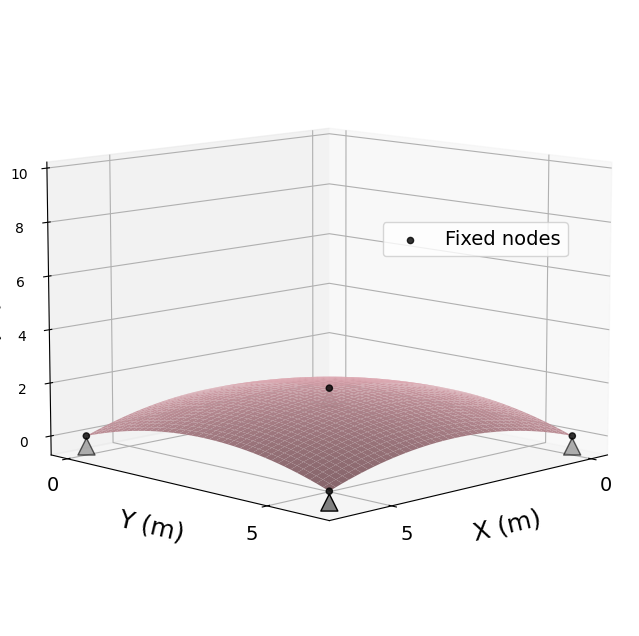

In [6]:
col = n_col+1
row = n_row+1 
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
X = xs.reshape((row,col))
Y = ys.reshape((row,col))
Z = zs.reshape((row,col))
ax.set_xlabel('X (m)',fontsize=18)
ax.set_ylabel('Y (m)',fontsize=18)
ax.set_zlabel('Z (m)',fontsize=18)
plt.yticks([0,5,10,15,20],fontsize=14)
plt.xticks([0,5,10,15,20],fontsize=14)

ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 10)
ax.plot_surface(X, Y, Z, color='pink')#cmap=plt.cm.YlGnBu_r) 
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],color='black',alpha=0.8,label='Fixed nodes',s=20)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes]-0.4, s=150, facecolors='grey', edgecolors='black',marker='^')
ax.view_init(10, 45)
plt.legend(loc=(0.6,0.6),fontsize=14)

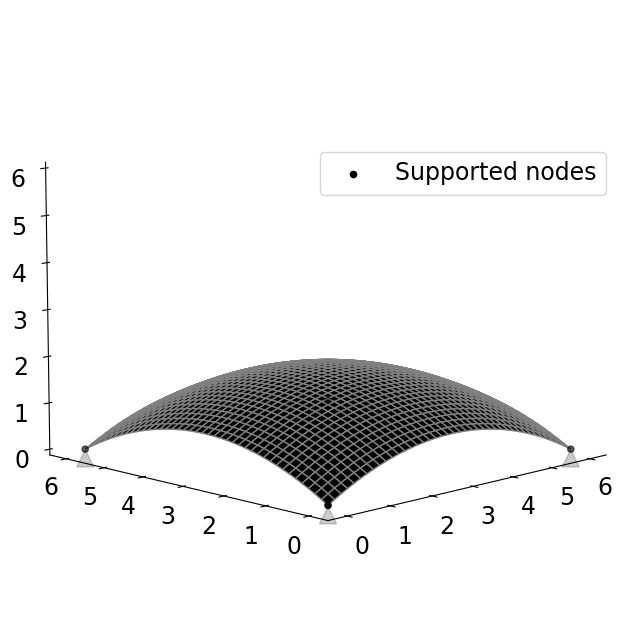

In [7]:
%matplotlib inline




fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,6)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=17)
ax.tick_params(axis='both', which='minor', labelsize=17)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
  #ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='black')

all_corners = []


for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    all_corners.append([[xs[inode],ys[inode],zs[inode]],
                        [xs[jnode],ys[jnode],zs[jnode]],
                        [xs[mnode],ys[mnode],zs[mnode]],
                        [xs[nnode],ys[nnode],zs[nnode]],
                       ])

tdco = Poly3DCollection(all_corners)
tdco.set_alpha(1)
tdco.set_facecolor('black')
tdco.set_edgecolor('grey')
ax.add_collection3d(tdco)

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],color='black',label='Supported nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(10, -135)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

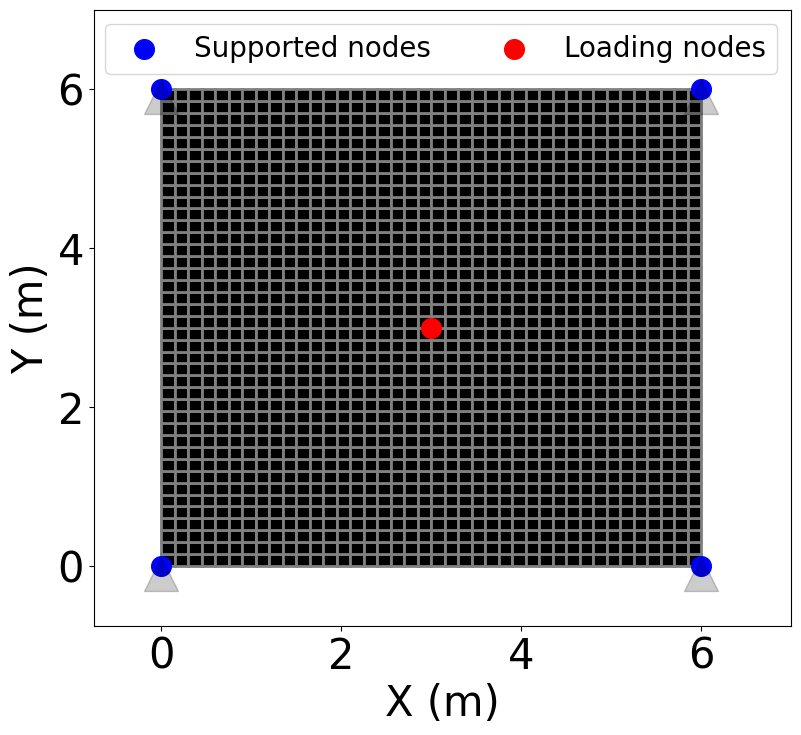

In [8]:
fig,ax = plt.subplots(figsize=(9,8))
ax.set_ylim(-0.75,7)
ax.set_xlim(-0.75,7)
#plt.title('{}-th iteration'.format(i))
plt.xlabel('X (m)',fontsize=30)
plt.ylabel('Y (m)',fontsize=30)
#ax = fig.add_subplot#(projection='3d')
#ax.set_zlim(0,20)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
all_corners= []
import matplotlib as mpl
cmap = mpl.colormaps['binary']
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
    alpha = float(1)
    #cthis_poly.set_alpha(alpha)
    this_poly.set_facecolor(cmap(alpha))
    this_poly.set_edgecolor('grey')
    this_poly.set_lw(2)
    ax.add_patch(this_poly)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='blue',s=200,label='Supported nodes')
ax.scatter(xs[loading_nodes],ys[loading_nodes],color='red',s=200,label='Loading nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes]-0.1,s=600,marker='^',alpha=0.2,color='black')


#cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
#cb.ax.tick_params(labelsize=20)
plt.legend(fontsize=20,ncol=2)# loc=(0.5,0.7))
ax.grid(False)
plt.show()

In [9]:
# Inputs of NN
# Embed some info
# 1. X,Y COORDINATES
# 2. Distance to the boundary: how close they are to the boundary
# 3. Centrality
from jax import vmap
def dis_boundary(x_nodes,y_nodes,non_design_nodes):
    '''
    Calculate the minimum distance of each node to the boundary node
    '''
    crd_xy = jnp.vstack((x_nodes.T,y_nodes.T)).T #shape (n_node,2)
    bound_xy = crd_xy[non_design_nodes,:] #xy of the boundary
    
    def xy_distance(xy_1,xy_2):
        return jnp.linalg.norm(xy_1-xy_2)
    xy_distance_vmap = vmap(xy_distance,in_axes=(None,0))
    vmap_norm = vmap(xy_distance_vmap,in_axes=(0,None))
    return jnp.min(vmap_norm(crd_xy,bound_xy),axis=1)

def v_centrality(x_nodes,y_nodes,non_design_nodes):
    '''
    Calculate the vertex centrality. Normalized so that minimum is "1".
    '''
    crd_xy = jnp.vstack((x_nodes.T,y_nodes.T)).T #shape (n_node,2)
    bound_xy = crd_xy[non_design_nodes,:] #xy of the boundary
    
    def xy_distance(xy_1,xy_2):
        return jnp.linalg.norm(xy_1-xy_2)
    xy_distance_vmap = vmap(xy_distance,in_axes=(None,0))
    vmap_norm = vmap(xy_distance_vmap,in_axes=(0,None))
    
    norm_min =jnp.min(jnp.sum(vmap_norm(crd_xy,bound_xy),axis=1))
    norm_max = jnp.max(jnp.sum(vmap_norm(crd_xy,bound_xy),axis=1))
    return (jnp.sum(vmap_norm(crd_xy,bound_xy),axis=1)-norm_min)/(norm_max-norm_min)

In [10]:
dis_b = dis_boundary(xs,ys,non_design_nodes)[design_nodes]
v_cen = v_centrality(xs,ys,non_design_nodes)

In [11]:
def Linear_filter(dist,R):
    '''
    A linear filter with radius R, will be normalized later to satisfy unit-intergral condition.
    '''
    return np.where(dist>R,0,(1/R)*(R-dist))

r = 0.05 #Radius

Mapping for nodal distance filter

In [12]:
#Matrix storing XY-projected distance  
dx_ij = xs[:,None]-xs[None,:]
dy_ij = ys[:,None]-ys[None,:]
D_ij = (dx_ij**2 + dy_ij**2)**0.5

#Create the filter mapping matrix
B_ij_ini = Linear_filter(D_ij,r)
B_ij_sum = np.sum(B_ij_ini,axis=1)
B_ij_sum = B_ij_sum.repeat(xs.shape[0]).reshape(xs.shape[0],xs.shape[0])
B_ij = B_ij_ini/B_ij_sum

In [13]:
zs_filtered = zs.copy()
zs_filtered[design_nodes] =(B_ij@zs_filtered)[design_nodes]

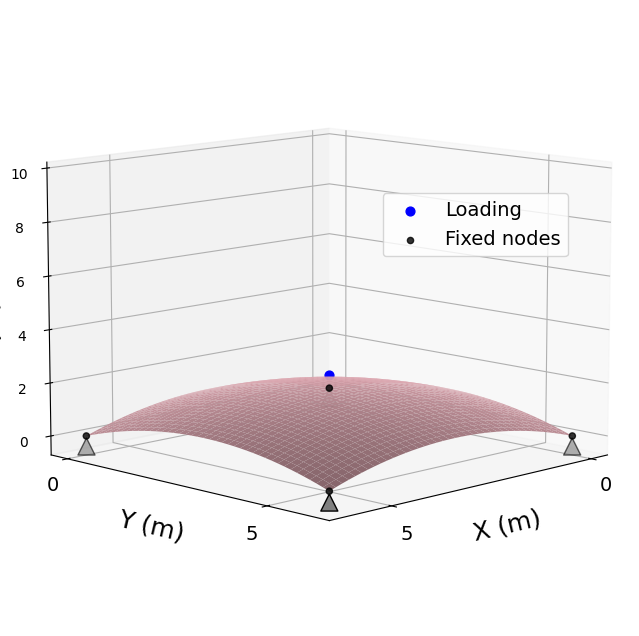

In [14]:
col = n_col+1
row = n_row+1 
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
X = xs.reshape((row,col))
Y = ys.reshape((row,col))
Z = zs_filtered.reshape((row,col))
ax.set_xlabel('X (m)',fontsize=18)
ax.set_ylabel('Y (m)',fontsize=18)
ax.set_zlabel('Z (m)',fontsize=18)
plt.yticks([0,5,10,15,20],fontsize=14)
plt.xticks([0,5,10,15,20],fontsize=14)

ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 10)
ax.plot_surface(X, Y, Z, color='pink')#cmap=plt.cm.YlGnBu_r) 
ax.scatter(xs[loading_nodes],ys[loading_nodes],zs_filtered[loading_nodes]+0.5,color='blue',label='Loading',s=40)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs_filtered[non_design_nodes],color='black',alpha=0.8,label='Fixed nodes',s=20)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs_filtered[non_design_nodes]-0.4, s=150, facecolors='grey', edgecolors='black',marker='^')
ax.view_init(10, 45)
plt.legend(loc=(0.6,0.6),fontsize=14)

Mapping for shell-center distance filter

In [15]:
xs_shell = np.average(xs[cnct],axis=1)
ys_shell = np.average(ys[cnct],axis=1)

In [16]:
#Matrix storing XY-projected distance  
dx_ij_shell = xs_shell[:,None]-xs_shell[None,:]
dy_ij_shell = ys_shell[:,None]-ys_shell[None,:]
D_ij_shell = (dx_ij_shell**2 + dy_ij_shell**2)**0.5

#Create the filter mapping matrix
B_ij_ini_shell = Linear_filter(D_ij_shell,0.25)
B_ij_sum_shell = np.sum(B_ij_ini_shell,axis=1)
B_ij_sum_shell = B_ij_sum_shell.repeat(xs_shell.shape[0]).reshape(xs_shell.shape[0],xs_shell.shape[0])
B_ij_shell = B_ij_ini_shell/B_ij_sum_shell

In [17]:
B_ij_shell.shape

(1600, 1600)

In [18]:
#W(A): total volume
def coeff_E(mu,p=8):
    '''
    SIMP: modified stiffness with penalty
    mu is vector representing shell element's density ratio, between 0 and 1.
    E= mu^p * E_0 (p is the penalty factor and it is taken as 5)
    ''' 
    global E
    return mu**p*E

def coeff_E2(mu):
    '''
    SIMP: modified stiffness with penalty
    mu is vector representing shell element's density ratio, between 0 and 1.
    E= mu^p * E_0 (p is the penalty factor and it is taken as 5)
    ''' 
    global E
    return mu**2*E


def og_p(p_norm):
    '''
    Return the un-normalized p
    '''
    p_max = 3
    p_min = 0
    return (p_max-p_min)*p_norm+p_min

def norm_p(p):
    p_max = 3
    p_min = 0
    return  (p-p_min)/(p_max-p_min)


def plt_plan(mu_opt_filtered,i=0):
    fig,ax = plt.subplots(figsize=(11,10))
    ax.set_ylim(-2,8)
    ax.set_xlim(-2,8)
    #plt.title('{}-th iteration'.format(i))
    plt.xlabel('X (m)',fontsize=30)
    plt.ylabel('Y (m)',fontsize=30)
    #ax = fig.add_subplot#(projection='3d')
    #ax.set_zlim(0,20)
    #ax.set_xlabel('X (m)',fontsize=15)
    #ax.set_ylabel('Y (m)',fontsize=15)
    #ax.set_zlabel('Z (m)',fontsize=15)
    all_corners= []
    import matplotlib as mpl
    cmap = mpl.colormaps['binary']
    for i in range(n_ele):
        inode = cnct[i,0]
        jnode = cnct[i,1]
        mnode = cnct[i,2]
        nnode = cnct[i,3]
        this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
        alpha = float(mu_opt_filtered[i])
        #cthis_poly.set_alpha(alpha)
        this_poly.set_facecolor(cmap(alpha))
        this_poly.set_edgecolor('black')
        this_poly.set_lw(2)
        ax.add_patch(this_poly)

    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.tick_params(axis='both', which='minor', labelsize=30)
    #Plot a basic wireframe.
    #for i in range(n_ele_bar):
    ##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

    ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='black',label='Non-design nodes')
    ax.scatter(xs[non_design_nodes],ys[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')


    cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
    cb.ax.tick_params(labelsize=20)
    plt.legend(fontsize=20)# loc=(0.5,0.7))
    ax.grid(False)
    plt.show()

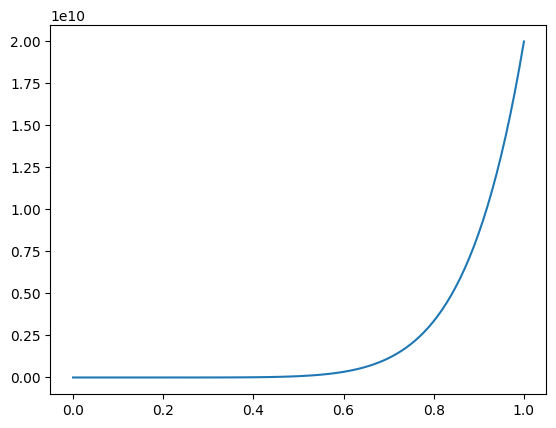

In [19]:
plt.plot(np.linspace(0,1,100),coeff_E(np.linspace(0,1,100)))

In [20]:
#%%
#Create model
model = Model.Model() #model for sensitivity analysis

#Adding nodes and boundary conditions
for i in range(n_node):
    model.add_node(i,xs[i],ys[i],zs_filtered[i])
    if i in non_design_nodes:
        model.add_support(i,[1,1,1,0,0,0]) #Pinned, only Ry allow
    if i in loading_nodes:
        model.add_nodal_load(i,nodal_load=[0.0,0.0,-Q,0.0,0.0,0.0])

#Adding elements
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    model.add_quad(i,inode, jnode, mnode, nnode, 
                t, E, nu)

model.model_ready()




In [21]:
model.solve()

In [22]:
# Start the SSO model
sso_model = SSO_model(model) # initial sso model

#Element parameter: 
for eletag in range(n_ele):
    eleparameter = ElementParameter(eletag,ele_type = 1,prop_type = 1) # element object, quad's young's modulus
    sso_model.add_eleparameter(eleparameter)


#Initial the parameters
sso_model.initialize_parameters_values()
sso_model.set_objective(objective='strain energy',func=None,func_args=None)

# NN

1. Input of NN: 
* XY of nodes

2. Outoput:
* Z
* Density ?


In [23]:
import pymesh
from flax import linen as nn

In [24]:
class SimpleNN(nn.Module):
    num_hidden : int   # Number of hidden neurons
    num_outputs : int  # Number of output neurons
    num_layers: int #Number of hidden layers

    @nn.compact  # Tells Flax to look for defined submodules
    def __call__(self, x):
        # Perform the calculation of the model to determine the prediction
        for i in range(self.num_layers):
            x = nn.Dense(features=self.num_hidden)(x)
            #x = nn.BatchNorm(use_running_average=not train)(x)
            x = nn.relu(x)
        x = nn.Dense(features=self.num_outputs)(x)
        x = nn.sigmoid(x) #Between 0 and 1
        return x

In [25]:
n_input = 2 #(X,Y) of each node
n_hidden = 40 # neurons
n_out = 1 #Z of each node & density
n_layers =3 #number of hidden layers

rng = jax.random.PRNGKey(42)

inp = np.abs(np.array([(xs-x_span/2)/np.max(xs),(ys-y_span/2)/np.max(ys)]).T)#,v_cen
#rng, inp_rng, init_rng = jax.random.split(rng, 3)

In [26]:
NN = SimpleNN(n_hidden,n_out,n_layers)

In [27]:
rng, init_rng = jax.random.split(rng, 2)
# Initialize the model
params = NN.init(init_rng, inp)

In [28]:
import optax
optimizer = optax.adam(learning_rate=0.01)

In [29]:
from flax.training import train_state

model_state = train_state.TrainState.create(apply_fn=NN.apply,
                                            params=params,
                                            tx=optimizer)

In [30]:
model_state.apply_fn(params, inp).shape

(1681, 1)

In [38]:
def calculate_loss(state, params, inp, alpha=0.1, p=2):


    ##Apply_fn: ML input to output
    outs = state.apply_fn(params, inp) #shape (n_node,2)
    node_rho_params = outs.reshape(-1)
    
    
    #sso_model.update_nodeparameter(z) # Update the model, this step causes "leak".... try directly call sso's function.
    
    #2. NN outputs to update topology (density, NN output is per-node density, average for each shell)
    ele_params = jnp.average(node_rho_params[cnct],axis=1) #Average per-node density for each shell
    filtered_mu = B_ij_shell@ele_params
    E_step = coeff_E(filtered_mu,p) #Penalized Young's modulus
    #sso_model.update_eleparameter(E_step) # Update the model
    
    #3. Loss function: penalized compliance
    parameter_values = E_step
    compliance = sso_model.helper_params_to_objective(parameter_values,which_solver='sparse',enforce_scipy_sparse=True)
    # loss = compliance (normalized) + alpha *(volume/exp_volume -1)^2
    loss1 = compliance/4
    loss2 = alpha*(jnp.sum(filtered_mu)/(0.5*sso_model.eleparameters_values.shape[0])-1)**2
    loss =  loss1 + loss2
    
    return loss#loss1,loss2,z,filtered_mu

In [39]:
calculate_loss(model_state,params,inp)

Array(0.09274151, dtype=float64)

In [40]:
grad_fn = jax.value_and_grad(calculate_loss,  # Function to calculate the loss
                                 argnums=1,  # Parameters are second argument of the function
                                 has_aux=False  # Function has additional outputs, here accuracy
                                )
    # Determine gradients for current model, parameters and batch
loss, grads = grad_fn(model_state, model_state.params, inp)

In [41]:
@jax.jit  # Jit the function for efficiency
def train_step(state, inp,alpha=0.1, p=2):
    # Gradient function
    grad_fn = jax.value_and_grad(calculate_loss,  # Function to calculate the loss
                                 argnums=1,  # Parameters are second argument of the function
                                 has_aux=False  # Function has additional outputs, here accuracy
                                )
    # Determine gradients for current model, parameters and batch
    loss, grads = grad_fn(state, state.params, inp,alpha, p)
    # Perform parameter update with gradients and optimizer
    state = state.apply_gradients(grads=grads)
    # Return state and any other value we might want
    return state, loss

In [42]:
%timeit train_step(model_state, inp)

1.37 s ± 9.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [43]:
metrics_history = {'train_loss': []}
from tqdm import tqdm
loss_list =[]
def train_model(state, num_epochs=200):
    alpha = 0.1
    p = 2
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        if alpha < 100:
            alpha = 0.1 +len(loss_list) * 0.05
        if p<8:
            p = 7.5#2 + 0.06*len(loss_list)
        state, loss = train_step(state, inp,alpha,p)
        metrics_history['train_loss'].append(loss)
        print('Train epoch {}'.format(len(metrics_history['train_loss'])+1)+'  ,loss:{}'.format(loss))
        # We could use the loss and accuracy for logging here, e.g. in TensorBoard
        # For simplicity, we skip this part here
        loss_list.append(loss)
        if len(loss_list)%5==0:
            i = len(loss_list)
            
            outs = state.apply_fn(state.params, inp) #shape (n_node,2)
            node_params = outs[:,0]
            node_rho_params = outs[:,1]



            #sso_model.update_nodeparameter(z) # Update the model, this step causes "leak".... try directly call sso's function.

            #2. NN outputs to update topology (density, NN output is per-node density, average for each shell)
            ele_params = jnp.average(node_rho_params[cnct],axis=1) #Average per-node density for each shell
            filtered_mu = B_ij_shell@ele_params
            E_step = coeff_E(filtered_mu) #Penalized Young's modulus
            print(jnp.sum(ele_params))
            
            plt_plan(filtered_mu,i)
    return state

  0%|          | 1/205 [00:11<40:02, 11.78s/it]

Train epoch 2  ,loss:4.953042626603026


  1%|          | 2/205 [00:13<19:09,  5.66s/it]

Train epoch 3  ,loss:2.1996894819307196


  1%|▏         | 3/205 [00:14<12:29,  3.71s/it]

Train epoch 4  ,loss:1.3477562572864024


  2%|▏         | 4/205 [00:15<09:21,  2.79s/it]

Train epoch 5  ,loss:0.8788527441712268
Train epoch 6  ,loss:0.5993305772672257
1311.142107069845


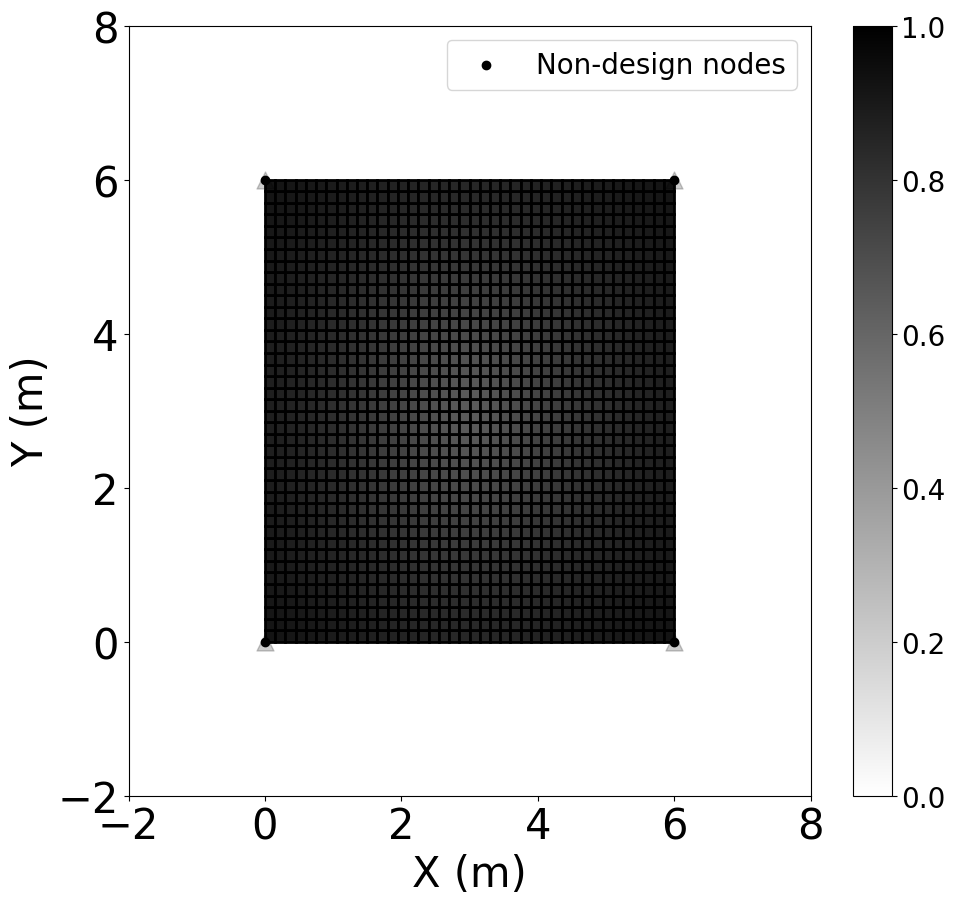

  3%|▎         | 6/205 [00:20<07:36,  2.30s/it]

Train epoch 7  ,loss:0.4549016662914269


  3%|▎         | 7/205 [00:21<06:35,  2.00s/it]

Train epoch 8  ,loss:0.4069537099834928


  4%|▍         | 8/205 [00:22<05:54,  1.80s/it]

Train epoch 9  ,loss:0.4180162288491141


  4%|▍         | 9/205 [00:24<05:26,  1.67s/it]

Train epoch 10  ,loss:0.45853150681125926
Train epoch 11  ,loss:0.5111273920320903
1543.7031003980528


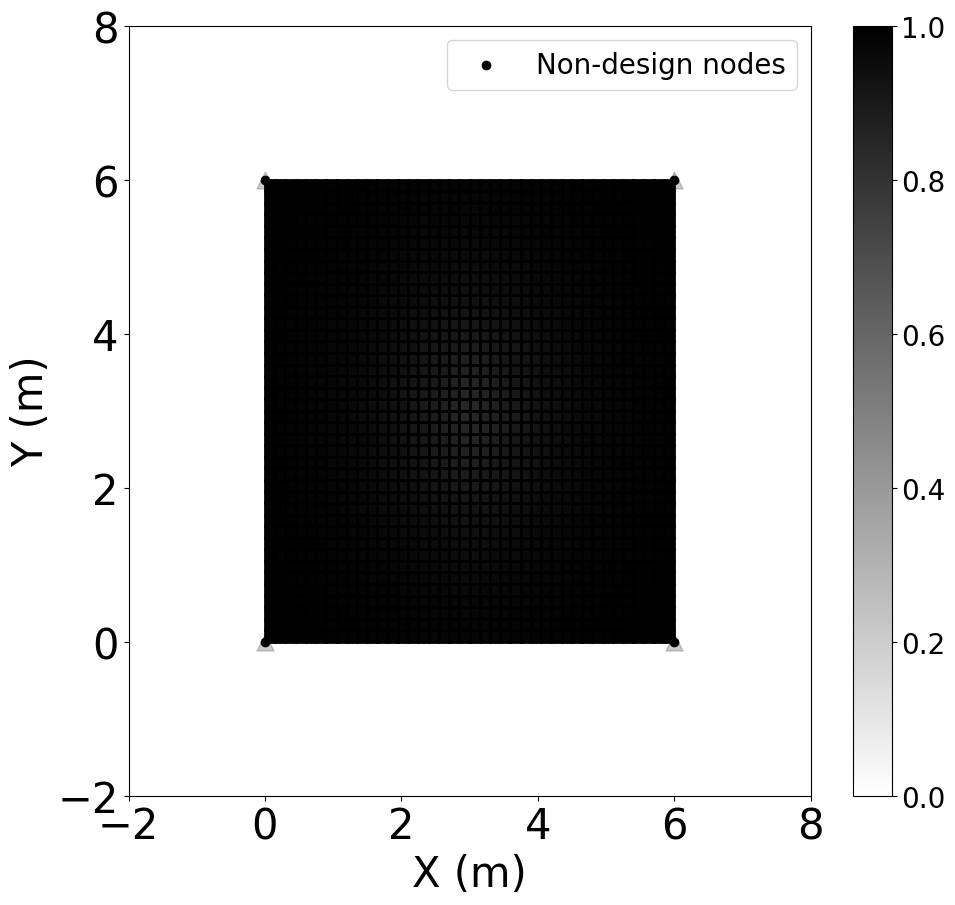

  5%|▌         | 11/205 [00:28<05:49,  1.80s/it]

Train epoch 12  ,loss:0.5673956812043457


  6%|▌         | 12/205 [00:29<05:22,  1.67s/it]

Train epoch 13  ,loss:0.6238916882512311


  6%|▋         | 13/205 [00:31<05:05,  1.59s/it]

Train epoch 14  ,loss:0.6794604437864827


  7%|▋         | 14/205 [00:32<04:51,  1.53s/it]

Train epoch 15  ,loss:0.733867499968661
Train epoch 16  ,loss:0.787187995533741
1580.7799242688307


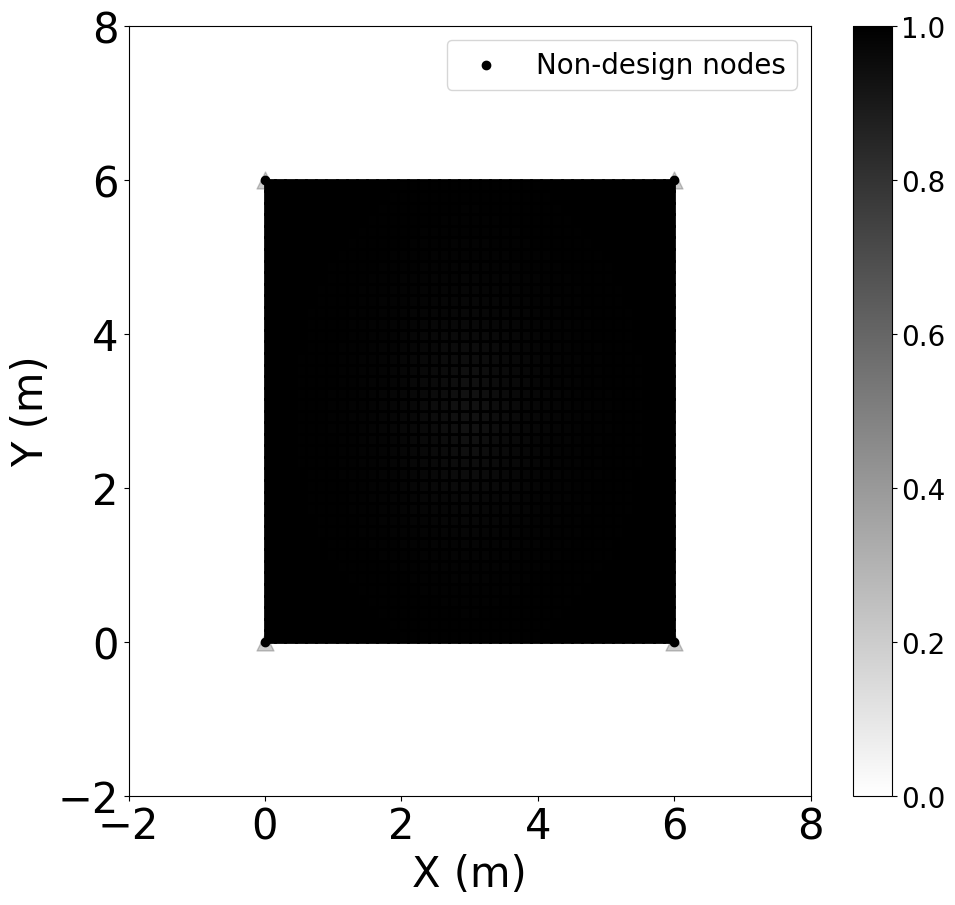

  8%|▊         | 16/205 [00:36<05:37,  1.79s/it]

Train epoch 17  ,loss:0.8395759182011066


  8%|▊         | 17/205 [00:38<05:12,  1.66s/it]

Train epoch 18  ,loss:0.8911755135997848


  9%|▉         | 18/205 [00:39<04:55,  1.58s/it]

Train epoch 19  ,loss:0.9421025597903543


  9%|▉         | 19/205 [00:40<04:42,  1.52s/it]

Train epoch 20  ,loss:0.992447354740586
Train epoch 21  ,loss:1.0422860339308835
1587.0473702283175


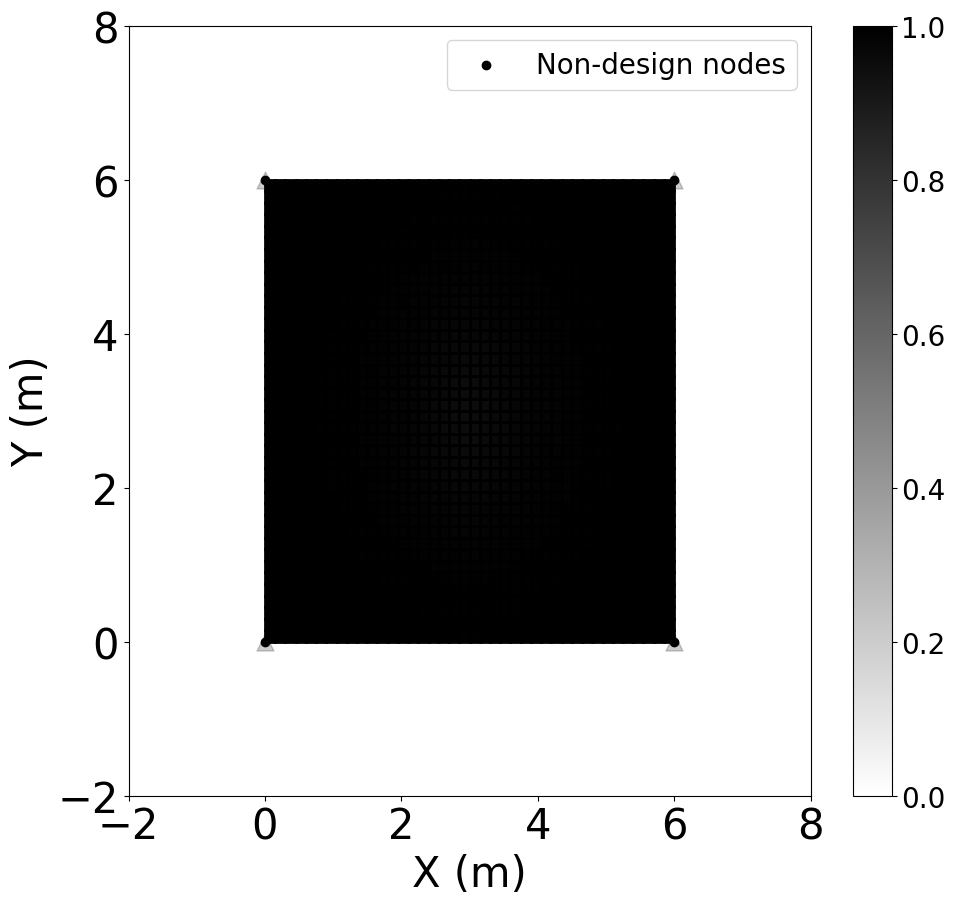

 10%|█         | 21/205 [00:44<05:17,  1.73s/it]

Train epoch 22  ,loss:1.0916513853414458


 11%|█         | 22/205 [00:46<04:56,  1.62s/it]

Train epoch 23  ,loss:1.1405437402703338


 11%|█         | 23/205 [00:47<04:41,  1.55s/it]

Train epoch 24  ,loss:1.1889444654833778


 12%|█▏        | 24/205 [00:49<04:31,  1.50s/it]

Train epoch 25  ,loss:1.2368241449260557
Train epoch 26  ,loss:1.2840674678549144
1586.102685978933


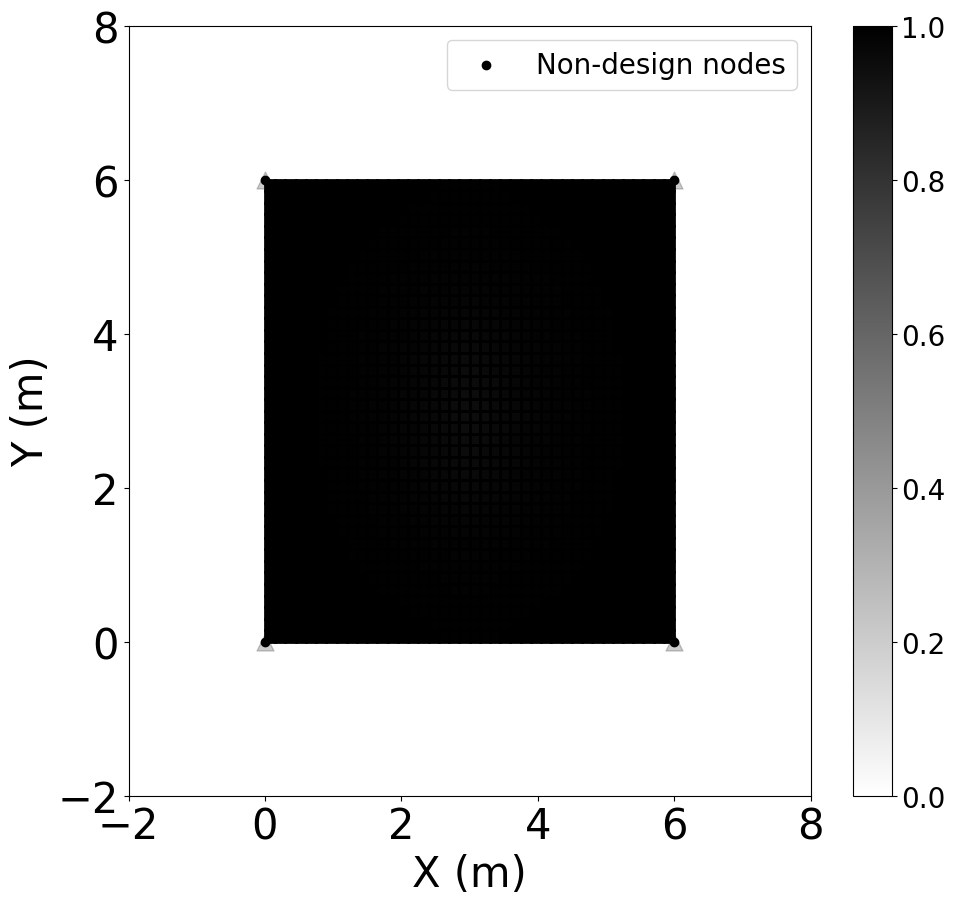

 13%|█▎        | 26/205 [00:53<05:18,  1.78s/it]

Train epoch 27  ,loss:1.3305497780006654


 13%|█▎        | 27/205 [00:54<04:55,  1.66s/it]

Train epoch 28  ,loss:1.3761054126089058


 14%|█▎        | 28/205 [00:56<04:38,  1.57s/it]

Train epoch 29  ,loss:1.4205125120763253


 14%|█▍        | 29/205 [00:57<04:26,  1.52s/it]

Train epoch 30  ,loss:1.463467723496554
Train epoch 31  ,loss:1.504559213467449
1578.1354618355904


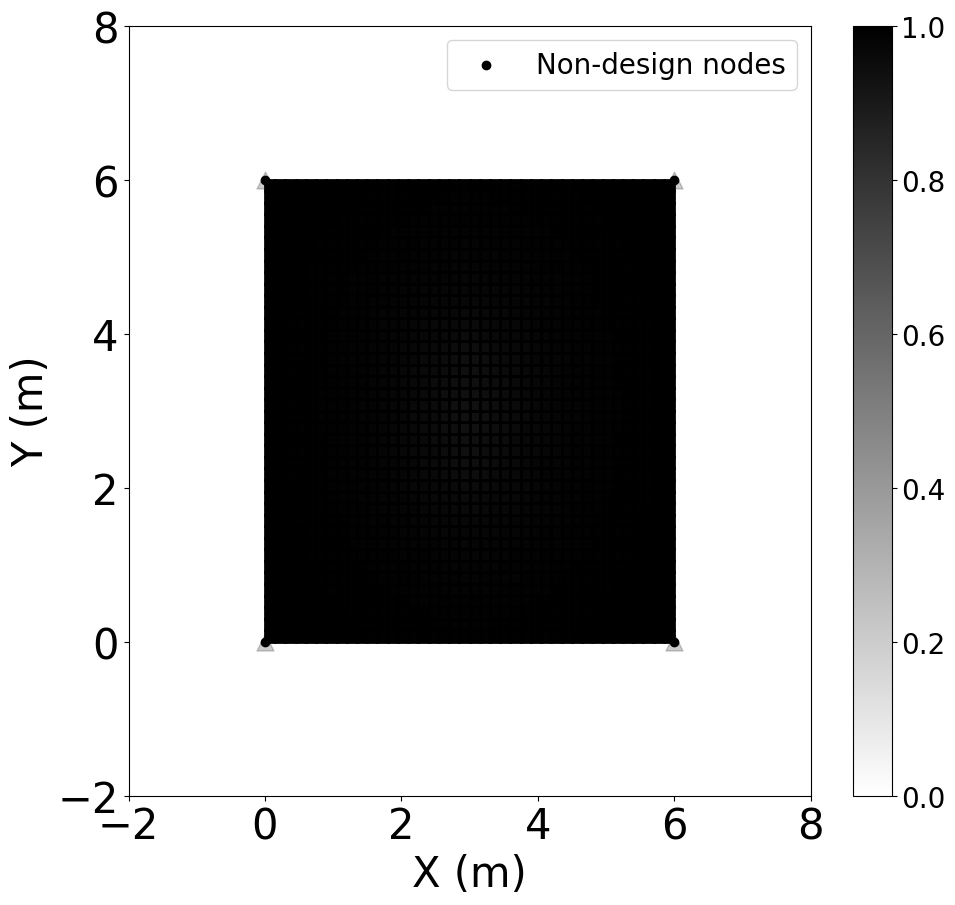

 15%|█▌        | 31/205 [01:01<05:01,  1.73s/it]

Train epoch 32  ,loss:1.5432284093498663


 16%|█▌        | 32/205 [01:03<04:41,  1.63s/it]

Train epoch 33  ,loss:1.5787151756787576


 16%|█▌        | 33/205 [01:04<04:27,  1.55s/it]

Train epoch 34  ,loss:1.6099725380509375


 17%|█▋        | 34/205 [01:05<04:16,  1.50s/it]

Train epoch 35  ,loss:1.635553999078859
Train epoch 36  ,loss:1.6534192855905276
1548.9611132276823


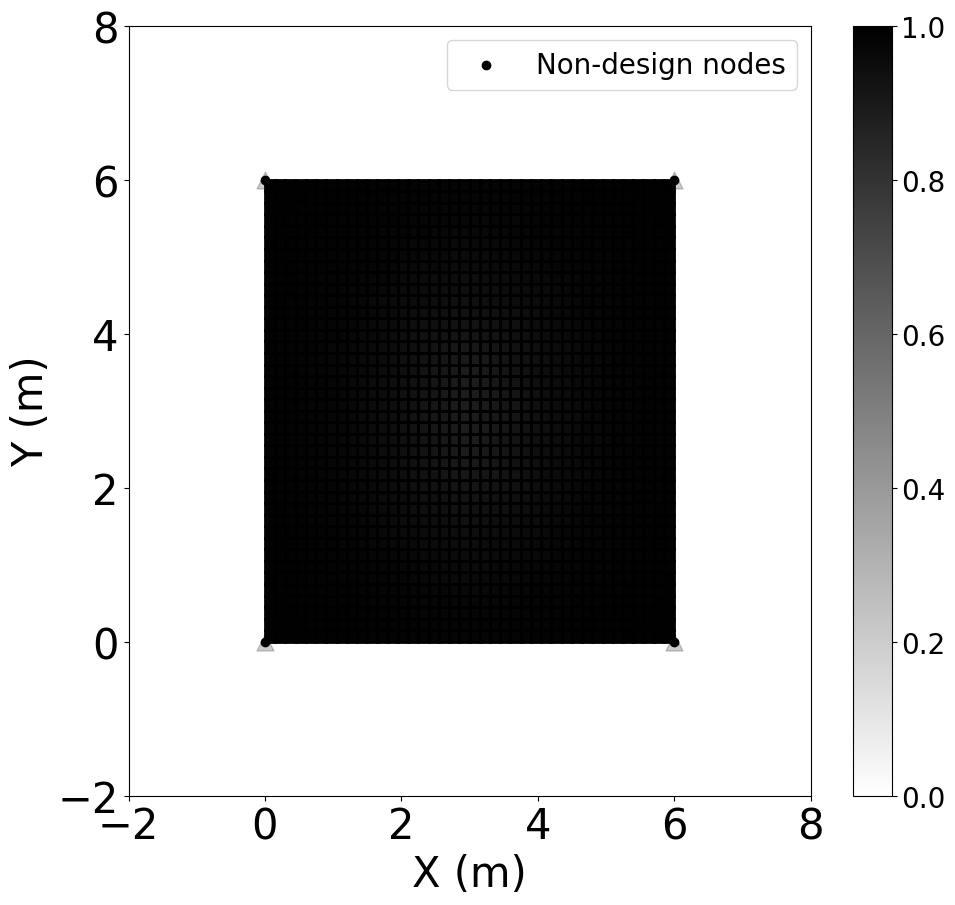

 18%|█▊        | 36/205 [01:10<05:01,  1.79s/it]

Train epoch 37  ,loss:1.6607184600768397


 18%|█▊        | 37/205 [01:11<04:39,  1.66s/it]

Train epoch 38  ,loss:1.6535904303644504


 19%|█▊        | 38/205 [01:13<04:23,  1.58s/it]

Train epoch 39  ,loss:1.6271476537732132


 19%|█▉        | 39/205 [01:14<04:11,  1.52s/it]

Train epoch 40  ,loss:1.5760294355605615
Train epoch 41  ,loss:1.495733690102817
1426.8378306132622


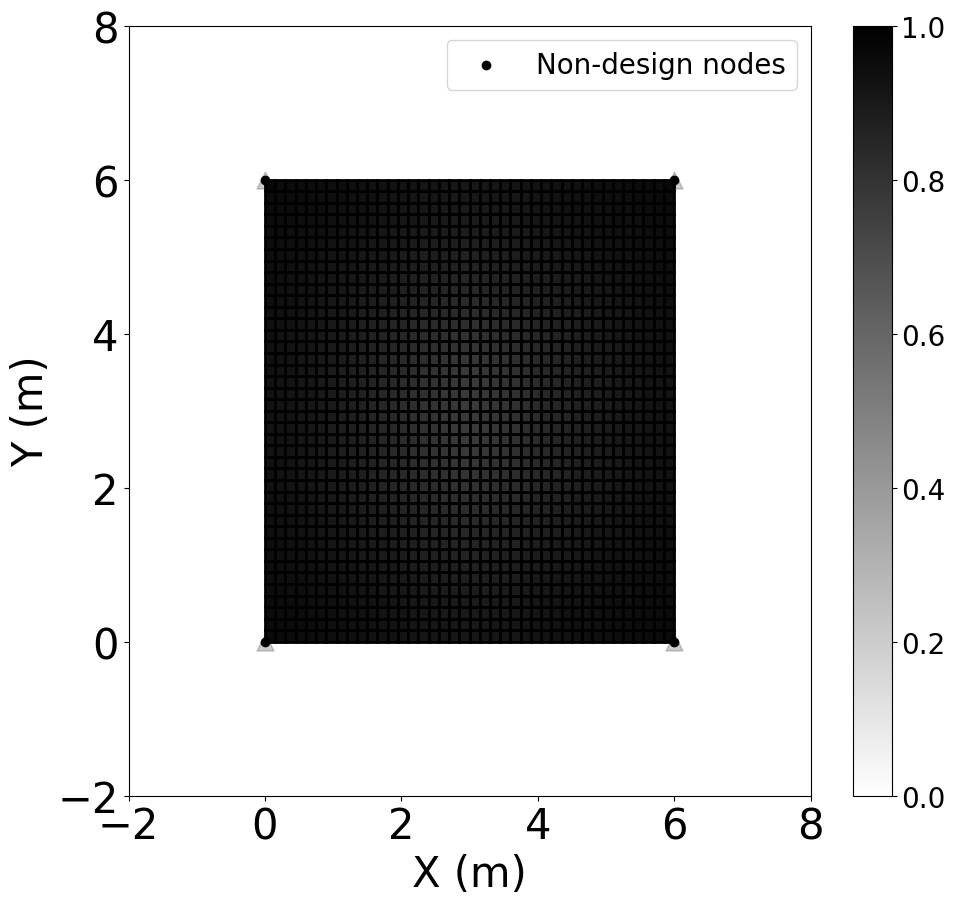

 20%|██        | 41/205 [01:18<04:42,  1.72s/it]

Train epoch 42  ,loss:1.385263509720508


 20%|██        | 42/205 [01:19<04:24,  1.62s/it]

Train epoch 43  ,loss:1.250160226164959


 21%|██        | 43/205 [01:21<04:10,  1.55s/it]

Train epoch 44  ,loss:1.105335007730174


 21%|██▏       | 44/205 [01:22<04:01,  1.50s/it]

Train epoch 45  ,loss:0.9731990881684
Train epoch 46  ,loss:0.8788993005405372
1128.843222385347


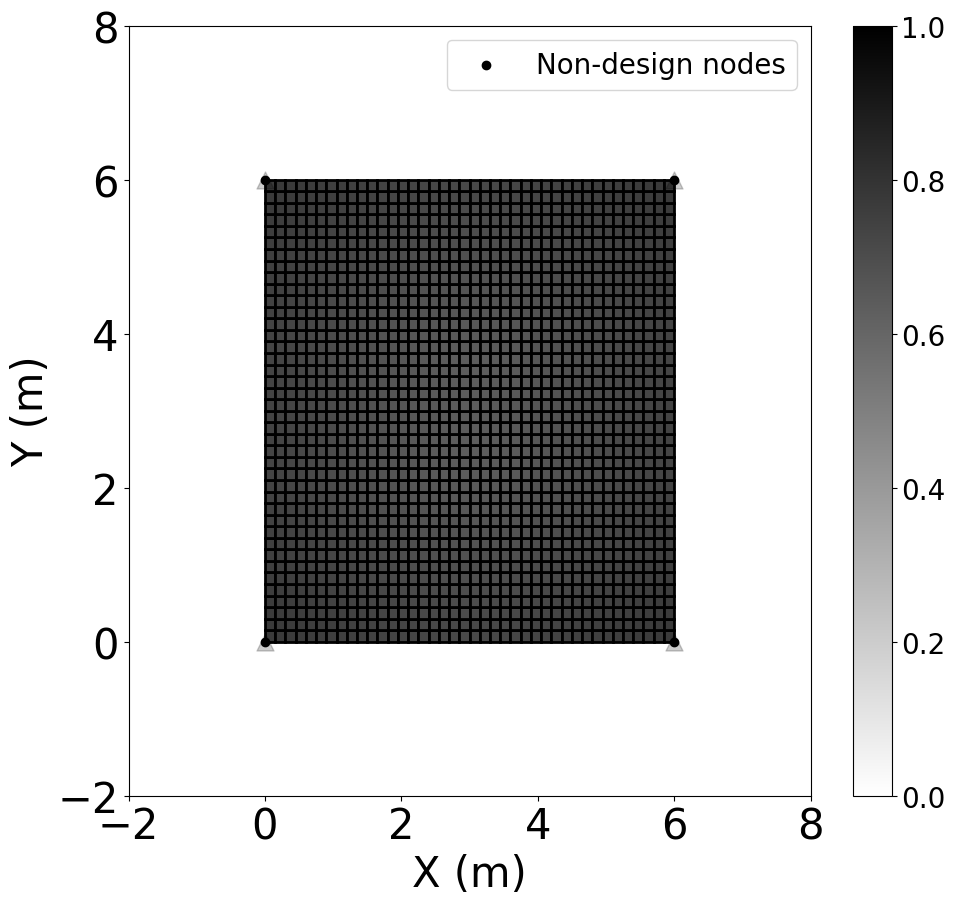

 22%|██▏       | 46/205 [01:27<04:42,  1.77s/it]

Train epoch 47  ,loss:0.8366947062099308


 23%|██▎       | 47/205 [01:28<04:21,  1.66s/it]

Train epoch 48  ,loss:0.8410508108626122


 23%|██▎       | 48/205 [01:29<04:06,  1.57s/it]

Train epoch 49  ,loss:0.8658334160049397


 24%|██▍       | 49/205 [01:31<03:57,  1.52s/it]

Train epoch 50  ,loss:0.8803873013689213
Train epoch 51  ,loss:0.8667409483566622
1010.5947487642904


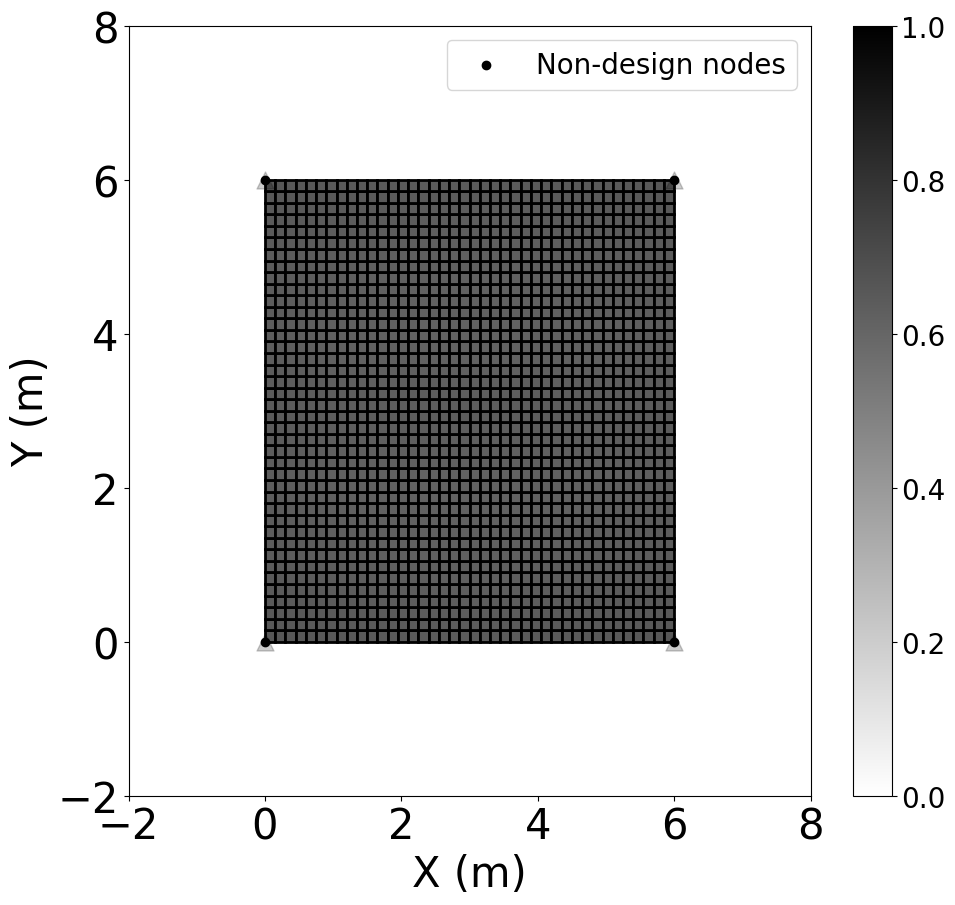

 25%|██▍       | 51/205 [01:35<04:25,  1.72s/it]

Train epoch 52  ,loss:0.8267178011491365


 25%|██▌       | 52/205 [01:36<04:07,  1.62s/it]

Train epoch 53  ,loss:0.7754605367463404


 26%|██▌       | 53/205 [01:37<03:55,  1.55s/it]

Train epoch 54  ,loss:0.7293659515619124


 26%|██▋       | 54/205 [01:39<03:46,  1.50s/it]

Train epoch 55  ,loss:0.701678246216946
Train epoch 56  ,loss:0.6975858296389998
1109.365858696061


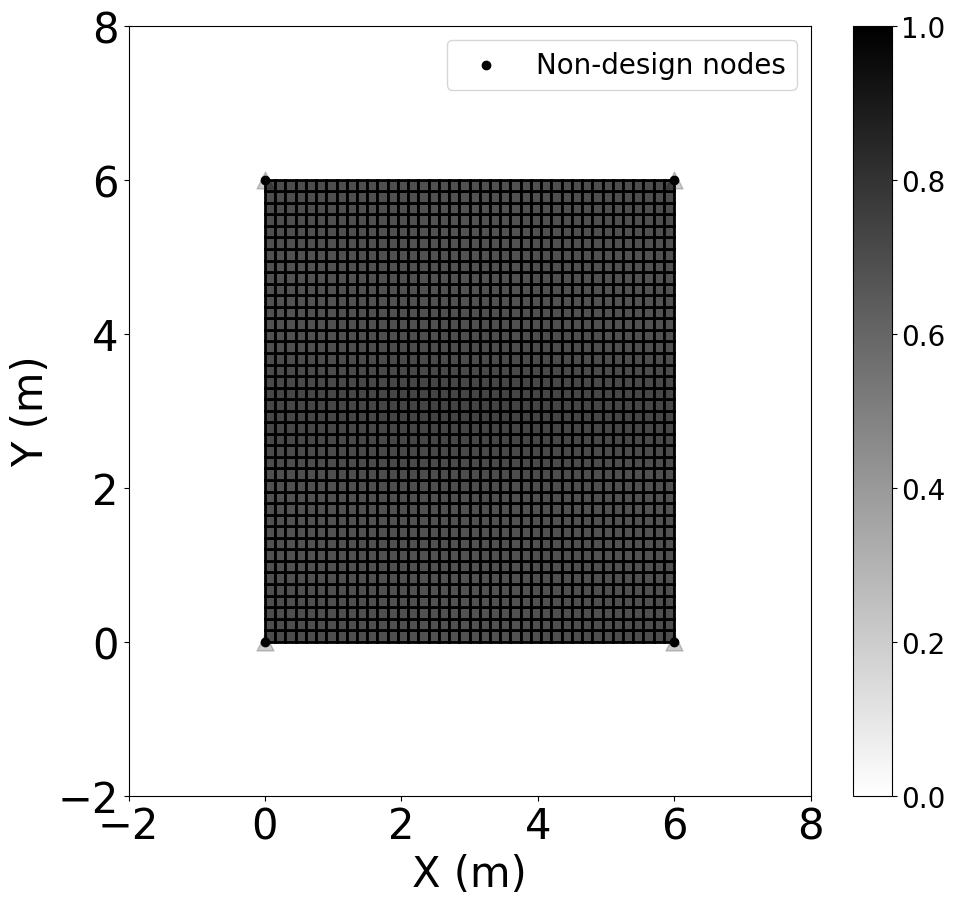

 27%|██▋       | 56/205 [01:43<04:15,  1.72s/it]

Train epoch 57  ,loss:0.70643822665029


 28%|██▊       | 57/205 [01:44<03:59,  1.62s/it]

Train epoch 58  ,loss:0.7131985679034654


 28%|██▊       | 58/205 [01:46<03:46,  1.54s/it]

Train epoch 59  ,loss:0.7095783123121778


 29%|██▉       | 59/205 [01:47<03:38,  1.49s/it]

Train epoch 60  ,loss:0.6964951400504998
Train epoch 61  ,loss:0.6781834216154333
1078.2195838508255


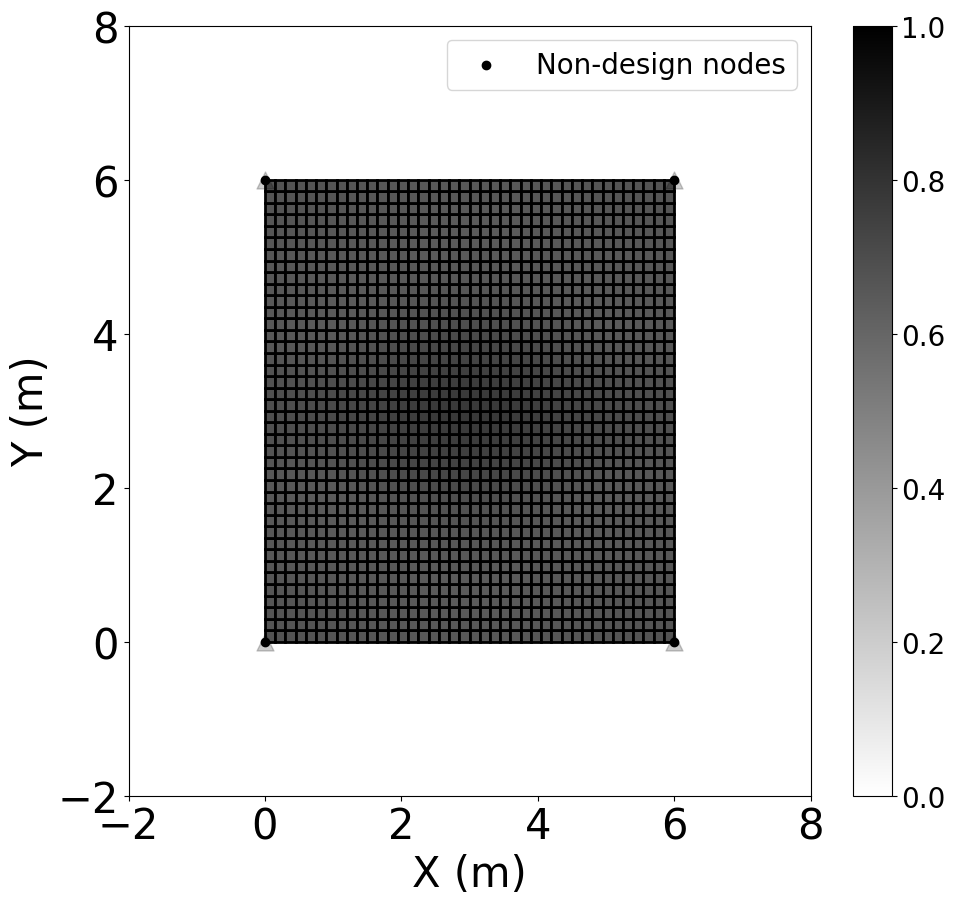

 30%|██▉       | 61/205 [01:52<04:16,  1.78s/it]

Train epoch 62  ,loss:0.6587851104258552


 30%|███       | 62/205 [01:53<03:56,  1.66s/it]

Train epoch 63  ,loss:0.6449561149212787


 31%|███       | 63/205 [01:54<03:43,  1.57s/it]

Train epoch 64  ,loss:0.6373147275300424


 31%|███       | 64/205 [01:56<03:33,  1.51s/it]

Train epoch 65  ,loss:0.6338688293859078
Train epoch 66  ,loss:0.6326091610981941
1025.534504463165


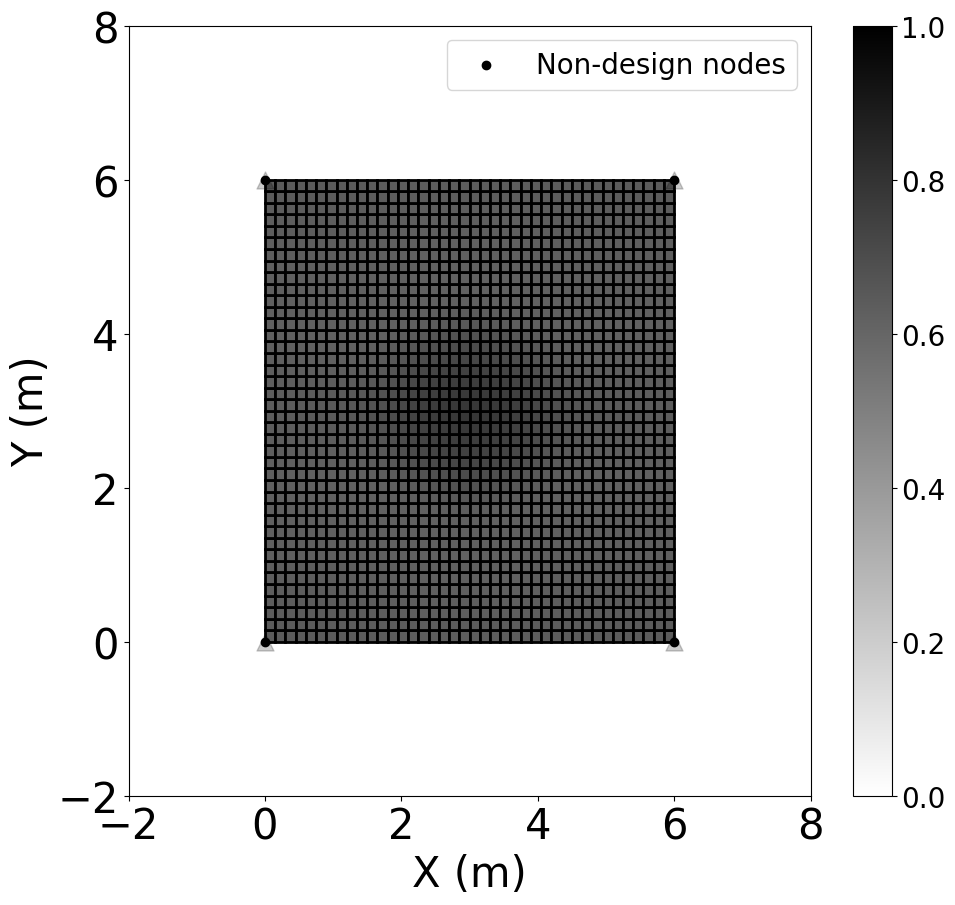

 32%|███▏      | 66/205 [02:00<03:58,  1.72s/it]

Train epoch 67  ,loss:0.6318688939746471


 33%|███▎      | 67/205 [02:01<03:42,  1.62s/it]

Train epoch 68  ,loss:0.6307136031609568


 33%|███▎      | 68/205 [02:02<03:31,  1.54s/it]

Train epoch 69  ,loss:0.6287966613288382


 34%|███▎      | 69/205 [02:04<03:22,  1.49s/it]

Train epoch 70  ,loss:0.6262377270151773
Train epoch 71  ,loss:0.6234153883320592
1020.2800535161284


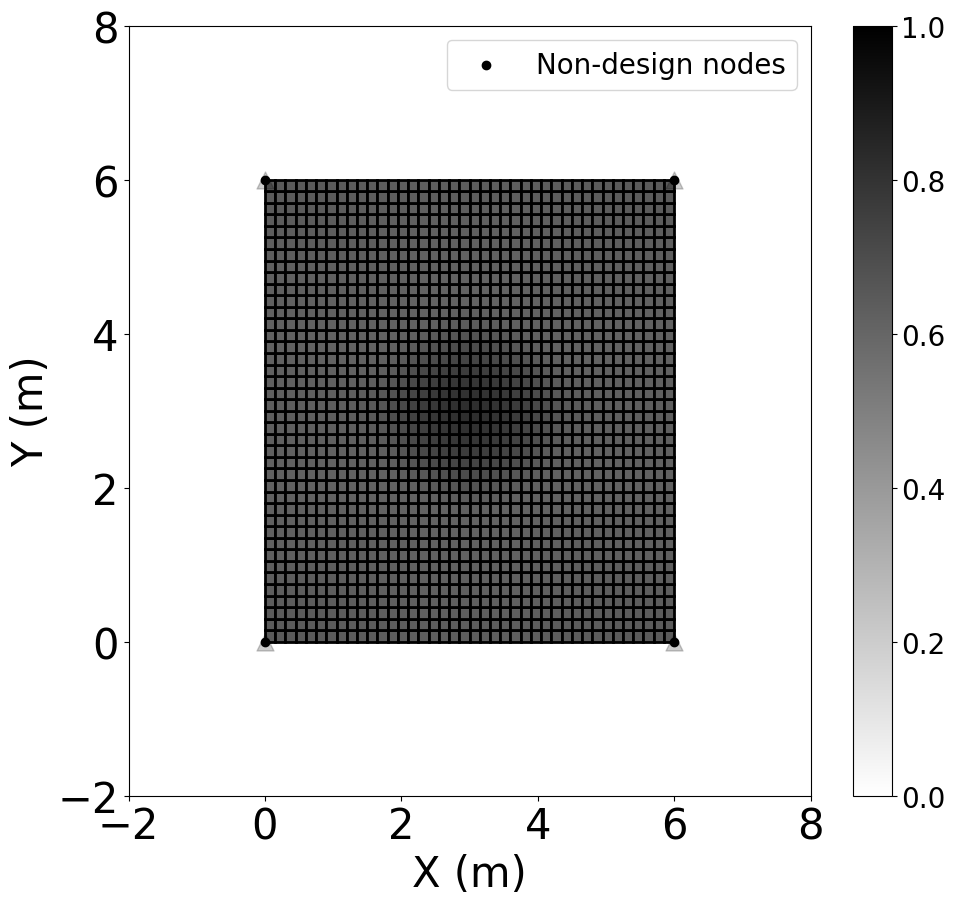

 35%|███▍      | 71/205 [02:08<03:57,  1.77s/it]

Train epoch 72  ,loss:0.6207810948230443


 35%|███▌      | 72/205 [02:10<03:40,  1.66s/it]

Train epoch 73  ,loss:0.6185789434692581


 36%|███▌      | 73/205 [02:11<03:27,  1.57s/it]

Train epoch 74  ,loss:0.6169630442407898


 36%|███▌      | 74/205 [02:12<03:18,  1.52s/it]

Train epoch 75  ,loss:0.615912704613132
Train epoch 76  ,loss:0.6153700262566058
1025.1056464816834


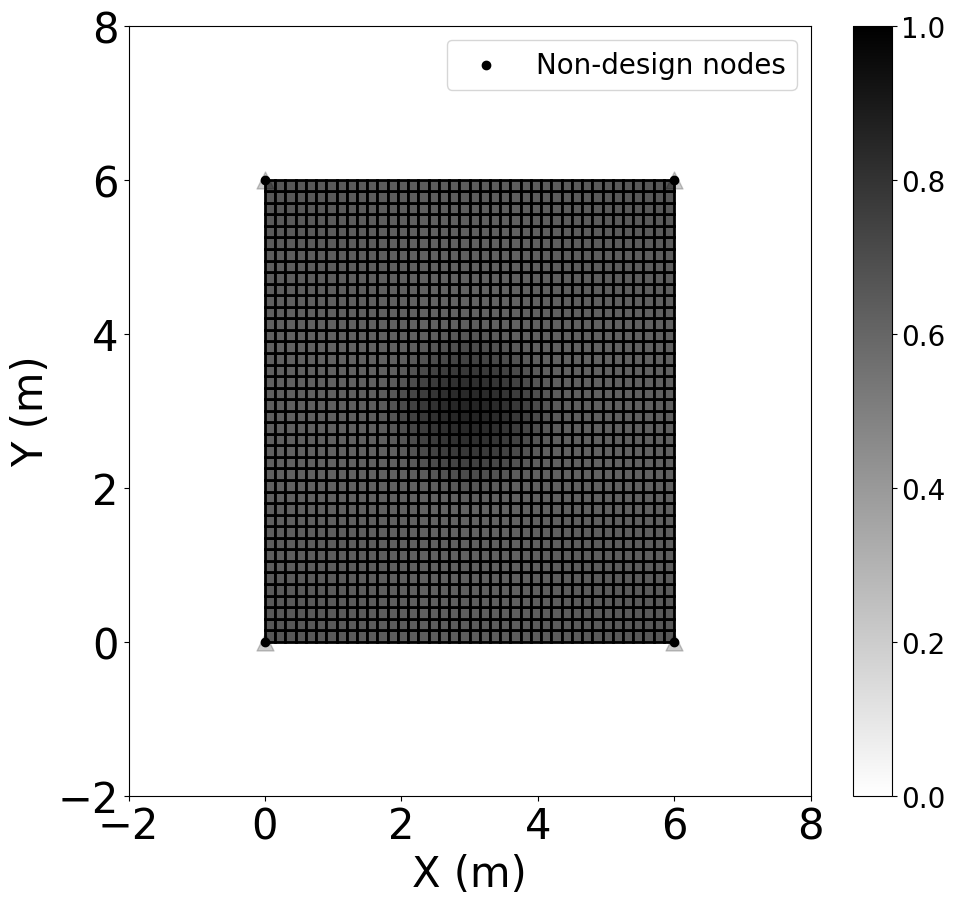

 37%|███▋      | 76/205 [02:16<03:43,  1.73s/it]

Train epoch 77  ,loss:0.6152156108066388


 38%|███▊      | 77/205 [02:18<03:28,  1.63s/it]

Train epoch 78  ,loss:0.6152855727566251


 38%|███▊      | 78/205 [02:19<03:17,  1.55s/it]

Train epoch 79  ,loss:0.6153269369151033


 39%|███▊      | 79/205 [02:21<03:08,  1.50s/it]

Train epoch 80  ,loss:0.6153588411656747
Train epoch 81  ,loss:0.615391722154796
1014.8167030206716


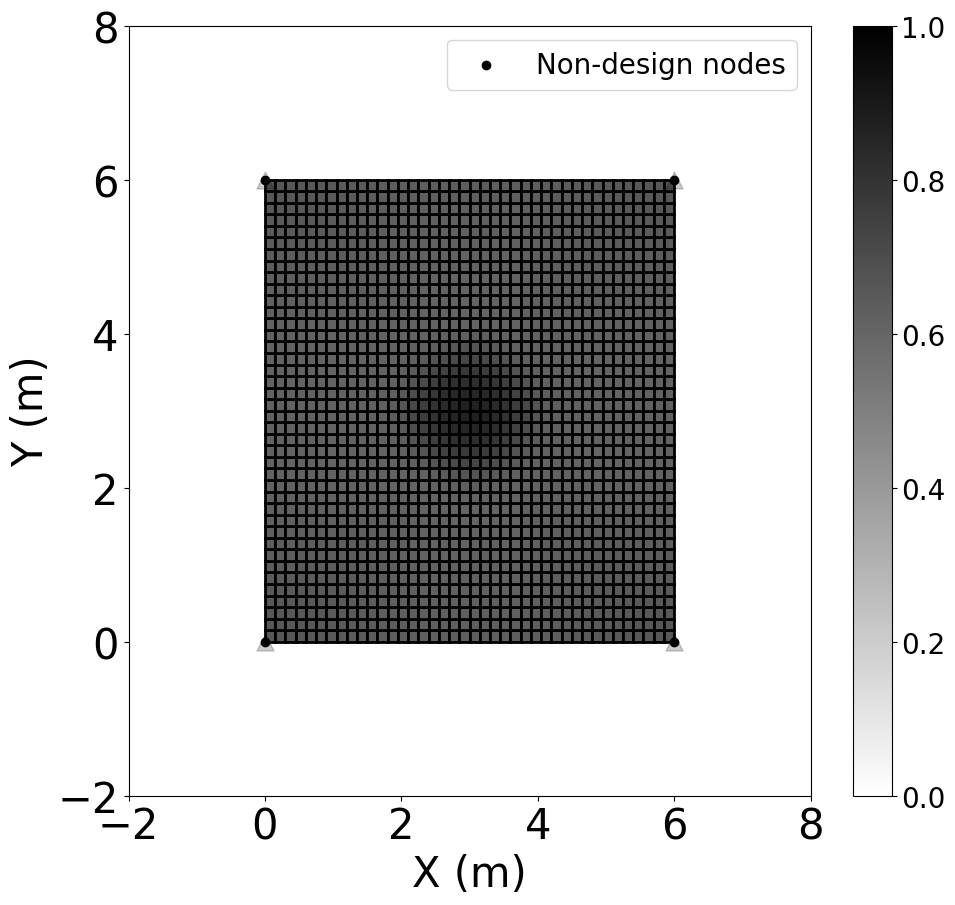

 40%|███▉      | 81/205 [02:25<03:41,  1.79s/it]

Train epoch 82  ,loss:0.615351042142334


 40%|████      | 82/205 [02:26<03:24,  1.67s/it]

Train epoch 83  ,loss:0.6152786948529789


 40%|████      | 83/205 [02:28<03:12,  1.58s/it]

Train epoch 84  ,loss:0.6151671939565868


 41%|████      | 84/205 [02:29<03:03,  1.52s/it]

Train epoch 85  ,loss:0.6149747255206677
Train epoch 86  ,loss:0.614718392443729
1001.499254792659


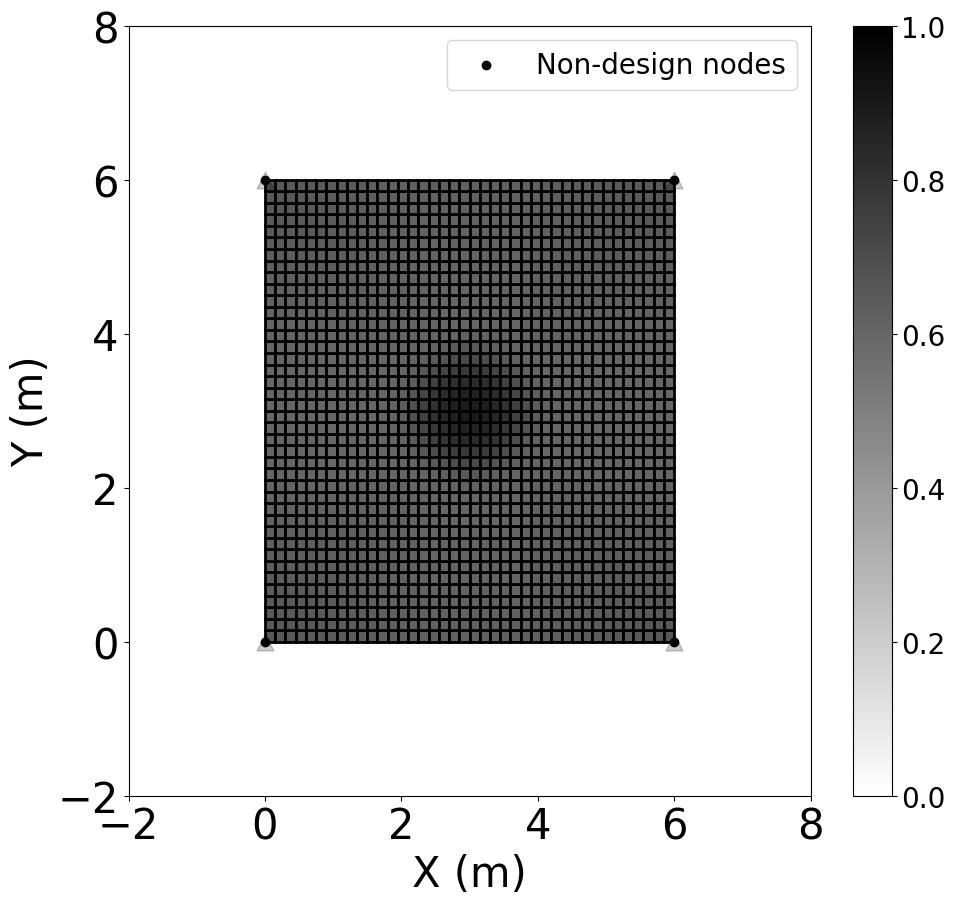

 42%|████▏     | 86/205 [02:33<03:25,  1.73s/it]

Train epoch 87  ,loss:0.6144091980575175


 42%|████▏     | 87/205 [02:35<03:11,  1.62s/it]

Train epoch 88  ,loss:0.6140564583210837


 43%|████▎     | 88/205 [02:36<03:01,  1.55s/it]

Train epoch 89  ,loss:0.6136517258827775


 43%|████▎     | 89/205 [02:37<02:54,  1.50s/it]

Train epoch 90  ,loss:0.6132203645374493
Train epoch 91  ,loss:0.6127346358246759
993.6943788080669


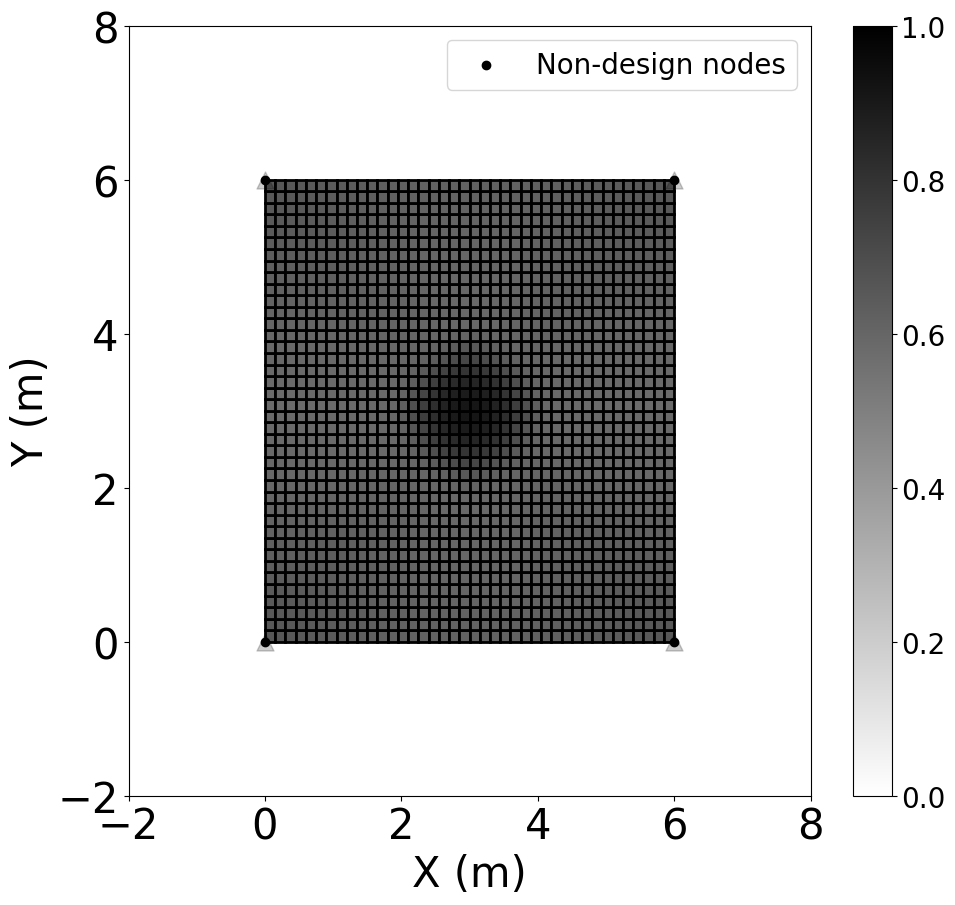

 44%|████▍     | 91/205 [02:42<03:23,  1.78s/it]

Train epoch 92  ,loss:0.6121120357444594


 45%|████▍     | 92/205 [02:43<03:07,  1.66s/it]

Train epoch 93  ,loss:0.6111236770796378


 45%|████▌     | 93/205 [02:45<02:56,  1.58s/it]

Train epoch 94  ,loss:0.6095209011851505


 46%|████▌     | 94/205 [02:46<02:48,  1.52s/it]

Train epoch 95  ,loss:0.6076227708270228
Train epoch 96  ,loss:0.6056170729336132
987.5408412413905


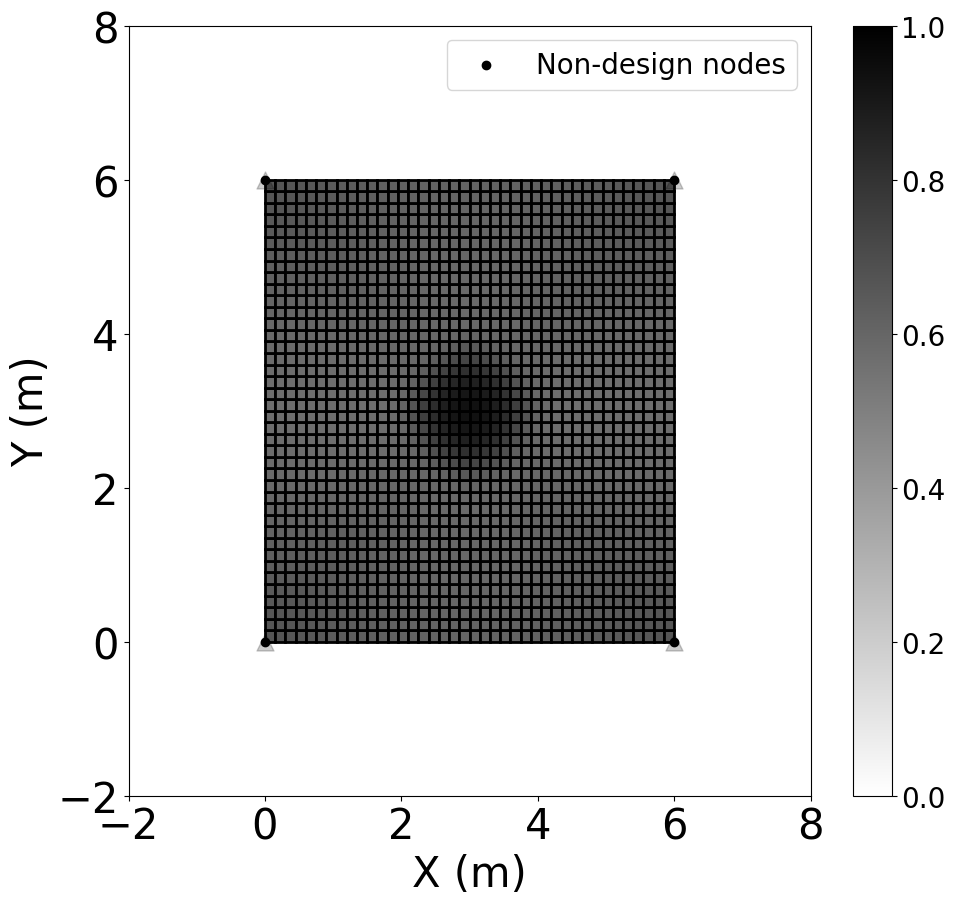

 47%|████▋     | 96/205 [02:50<03:08,  1.73s/it]

Train epoch 97  ,loss:0.6035022696171186


 47%|████▋     | 97/205 [02:51<02:55,  1.63s/it]

Train epoch 98  ,loss:0.601182221120009


 48%|████▊     | 98/205 [02:53<02:46,  1.55s/it]

Train epoch 99  ,loss:0.598710277321598


 48%|████▊     | 99/205 [02:54<02:39,  1.51s/it]

Train epoch 100  ,loss:0.5968555250295373
Train epoch 101  ,loss:0.593960025769072
980.3717277525275


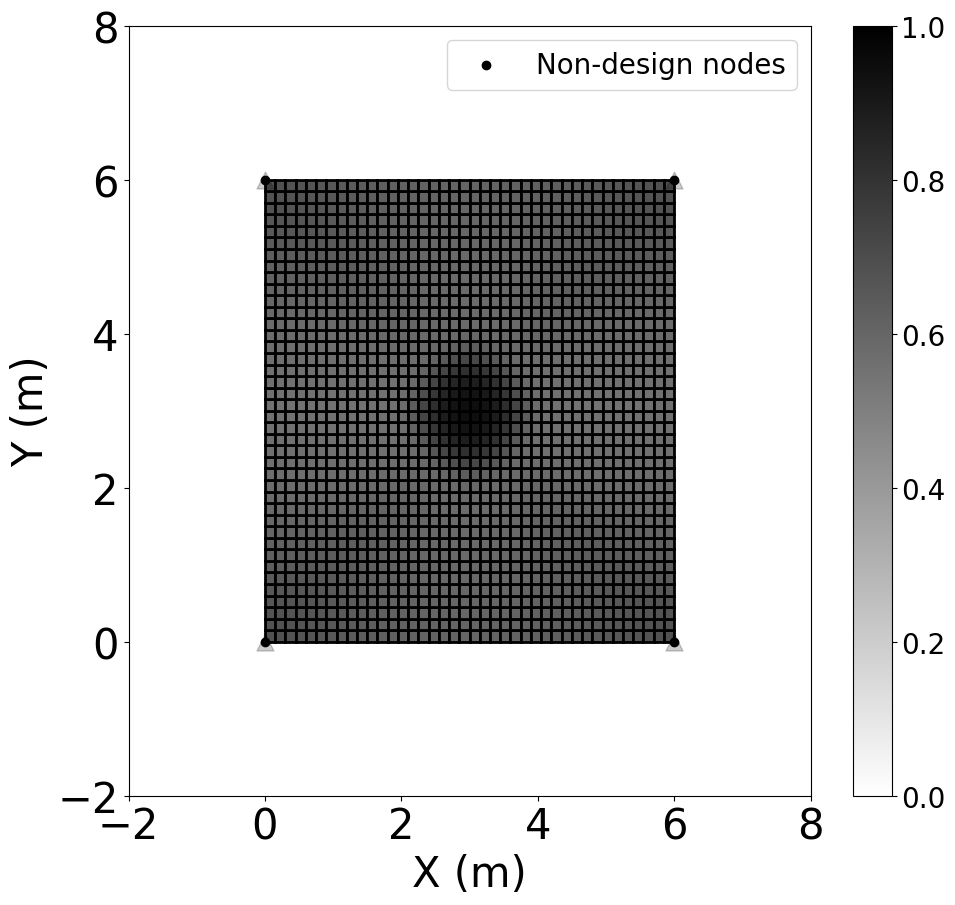

 49%|████▉     | 101/205 [02:58<02:58,  1.71s/it]

Train epoch 102  ,loss:0.5914628390491387


 50%|████▉     | 102/205 [03:00<02:45,  1.61s/it]

Train epoch 103  ,loss:0.5884357446671684


 50%|█████     | 103/205 [03:01<02:37,  1.54s/it]

Train epoch 104  ,loss:0.5847641051096255


 51%|█████     | 104/205 [03:02<02:30,  1.49s/it]

Train epoch 105  ,loss:0.5811218508037068
Train epoch 106  ,loss:0.576563515931622
968.279866220787


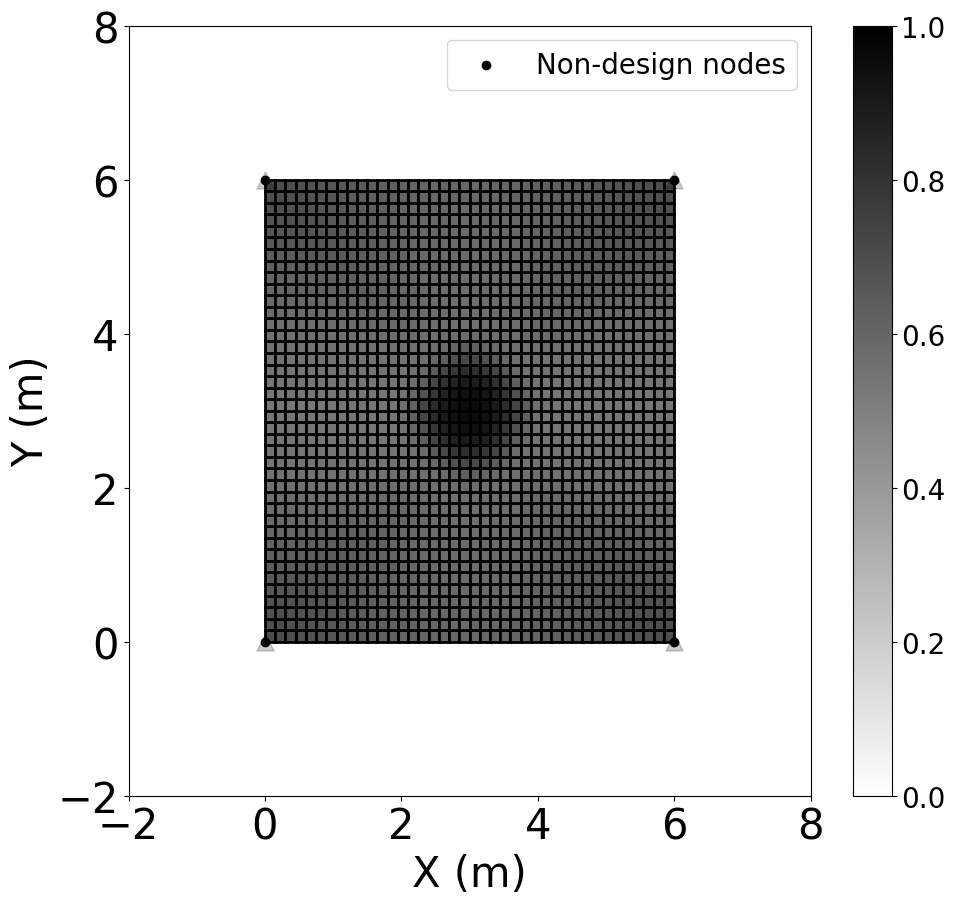

 52%|█████▏    | 106/205 [03:07<02:55,  1.78s/it]

Train epoch 107  ,loss:0.5710536499285729


 52%|█████▏    | 107/205 [03:08<02:42,  1.66s/it]

Train epoch 108  ,loss:0.5652608646291617


 53%|█████▎    | 108/205 [03:10<02:33,  1.58s/it]

Train epoch 109  ,loss:0.558316223649351


 53%|█████▎    | 109/205 [03:11<02:25,  1.52s/it]

Train epoch 110  ,loss:0.5501447903537734
Train epoch 111  ,loss:0.5413200969203251
949.3724592332135


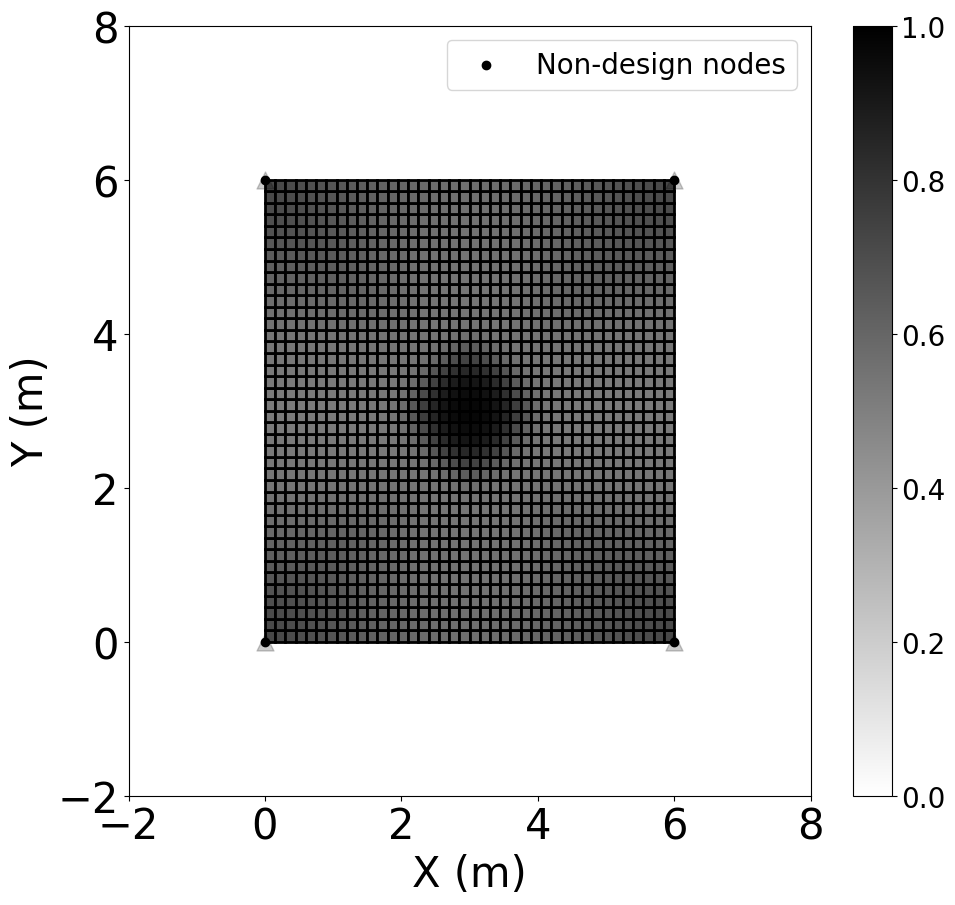

 54%|█████▍    | 111/205 [03:15<02:41,  1.72s/it]

Train epoch 112  ,loss:0.5311169582211495


 55%|█████▍    | 112/205 [03:16<02:30,  1.61s/it]

Train epoch 113  ,loss:0.5205473552373324


 55%|█████▌    | 113/205 [03:18<02:21,  1.54s/it]

Train epoch 114  ,loss:0.5103780826938412


 56%|█████▌    | 114/205 [03:19<02:15,  1.49s/it]

Train epoch 115  ,loss:0.5007161860959741
Train epoch 116  ,loss:0.49171423414650395
940.7603107428281


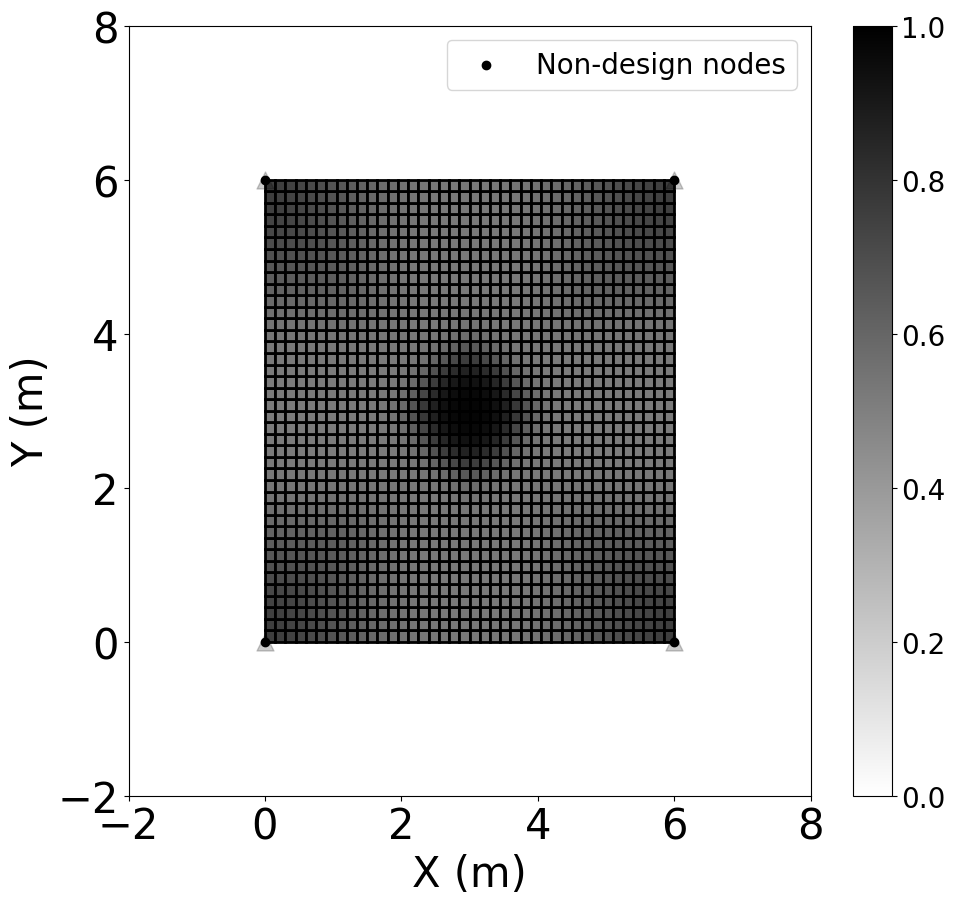

 57%|█████▋    | 116/205 [03:23<02:38,  1.78s/it]

Train epoch 117  ,loss:0.4833024184997237


 57%|█████▋    | 117/205 [03:25<02:25,  1.66s/it]

Train epoch 118  ,loss:0.47518374162704946


 58%|█████▊    | 118/205 [03:26<02:17,  1.58s/it]

Train epoch 119  ,loss:0.4677316628969451


 58%|█████▊    | 119/205 [03:28<02:11,  1.52s/it]

Train epoch 120  ,loss:0.4604837250699294
Train epoch 121  ,loss:0.4537334725103197
931.6010860309993


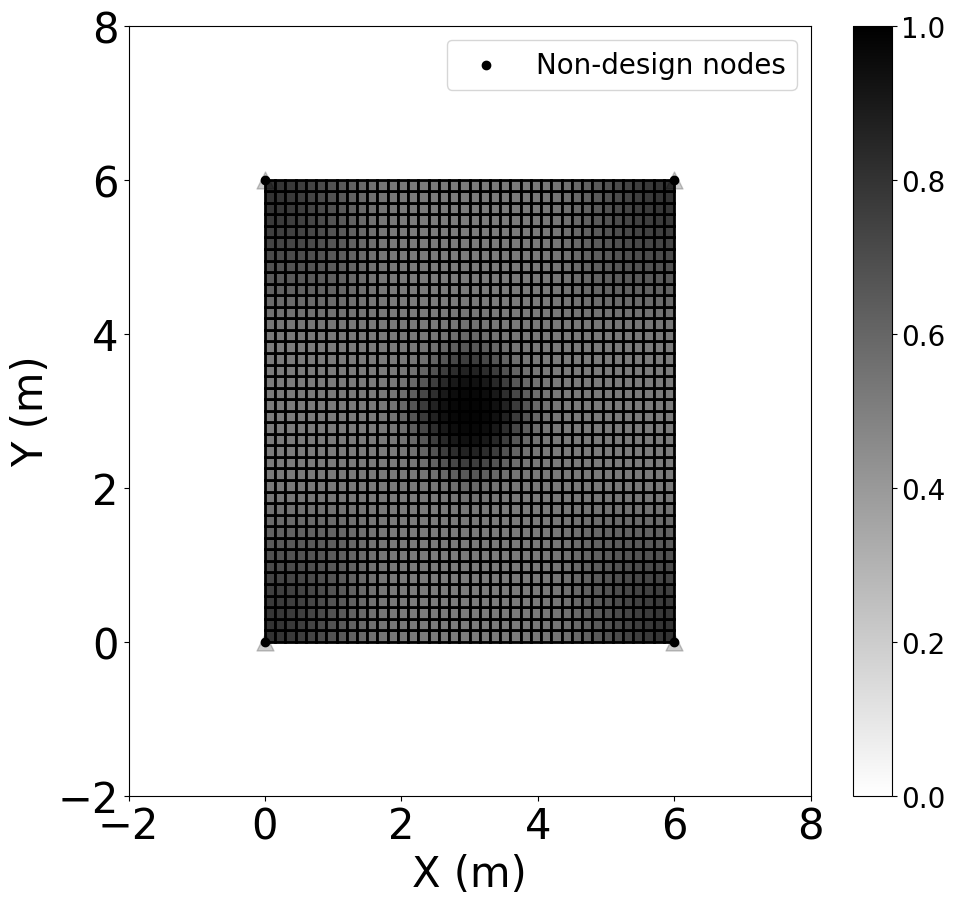

 59%|█████▉    | 121/205 [03:32<02:25,  1.73s/it]

Train epoch 122  ,loss:0.44747366834238234


 60%|█████▉    | 122/205 [03:33<02:14,  1.62s/it]

Train epoch 123  ,loss:0.44174431500311184


 60%|██████    | 123/205 [03:34<02:06,  1.55s/it]

Train epoch 124  ,loss:0.4364717472193298


 60%|██████    | 124/205 [03:36<02:00,  1.49s/it]

Train epoch 125  ,loss:0.4314602998680389
Train epoch 126  ,loss:0.42667706777714404
923.0478644443058


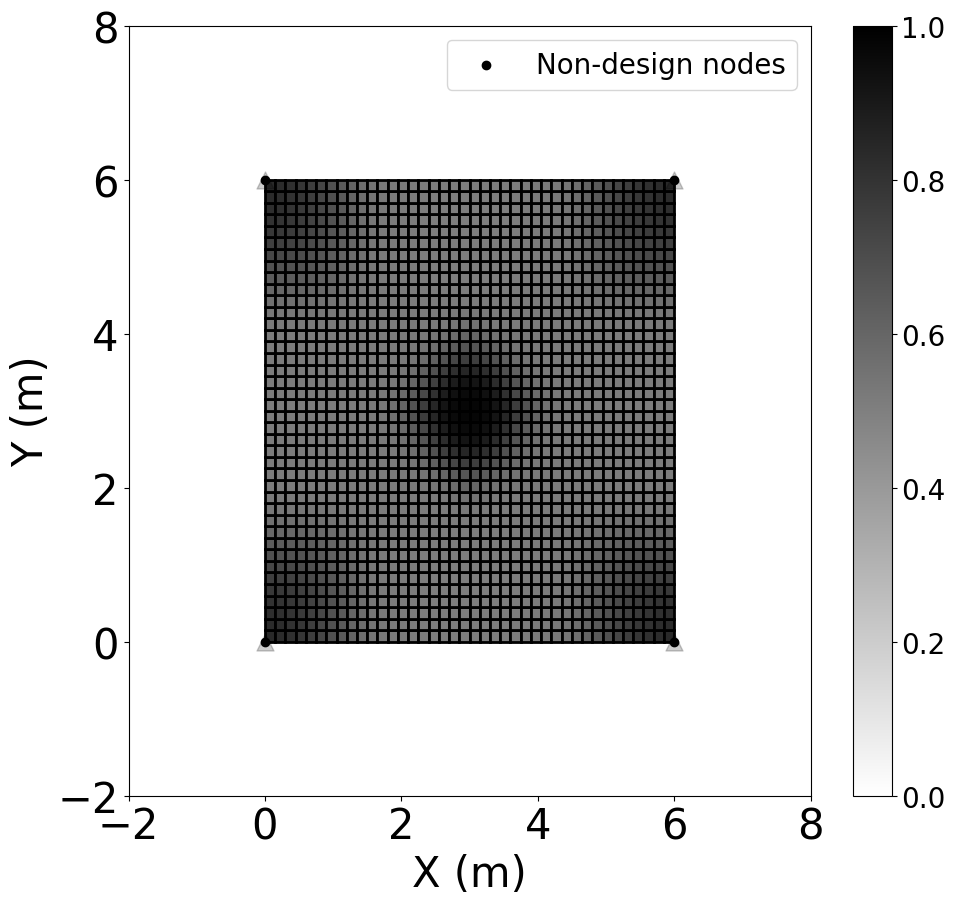

 61%|██████▏   | 126/205 [03:40<02:20,  1.78s/it]

Train epoch 127  ,loss:0.4222389518313774


 62%|██████▏   | 127/205 [03:42<02:15,  1.74s/it]

Train epoch 128  ,loss:0.41791613405176775


 62%|██████▏   | 128/205 [03:43<02:05,  1.63s/it]

Train epoch 129  ,loss:0.4137173745525514


 63%|██████▎   | 129/205 [03:45<01:57,  1.55s/it]

Train epoch 130  ,loss:0.40968691546223
Train epoch 131  ,loss:0.4056994184624002
914.7244593345436


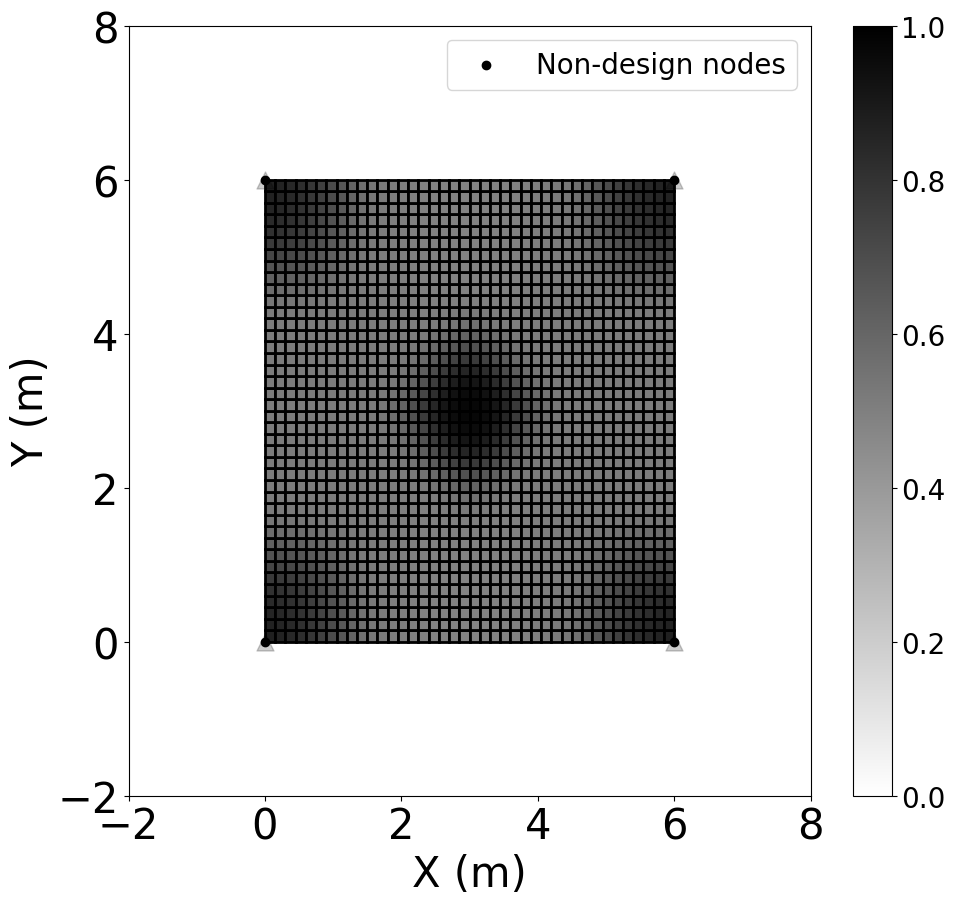

 64%|██████▍   | 131/205 [03:49<02:08,  1.74s/it]

Train epoch 132  ,loss:0.40173154949870926


 64%|██████▍   | 132/205 [03:50<01:58,  1.63s/it]

Train epoch 133  ,loss:0.39753054739505467


 65%|██████▍   | 133/205 [03:51<01:51,  1.55s/it]

Train epoch 134  ,loss:0.39307535850297964


 65%|██████▌   | 134/205 [03:53<01:46,  1.50s/it]

Train epoch 135  ,loss:0.388253980609664
Train epoch 136  ,loss:0.3819567273138753
898.1465664857049


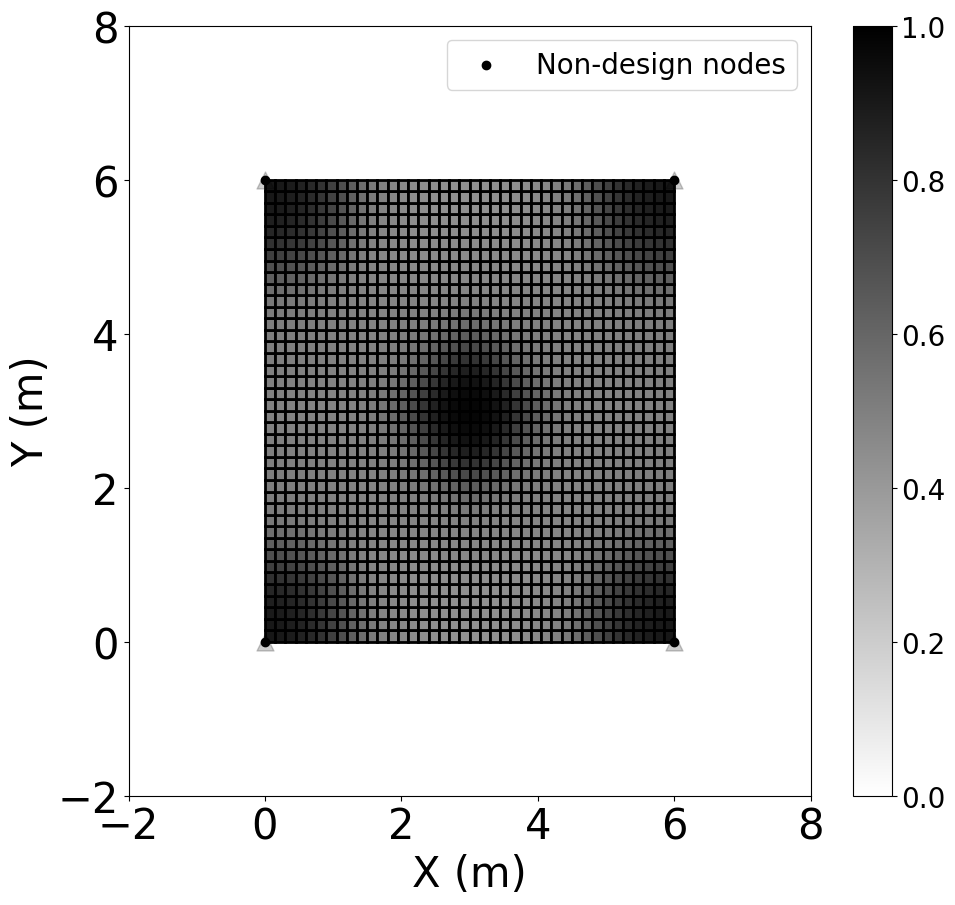

 66%|██████▋   | 136/205 [03:57<01:57,  1.71s/it]

Train epoch 137  ,loss:0.3744396543962338


 67%|██████▋   | 137/205 [03:58<01:49,  1.61s/it]

Train epoch 138  ,loss:0.36894030874243866


 67%|██████▋   | 138/205 [04:00<01:42,  1.54s/it]

Train epoch 139  ,loss:0.3667137779562089


 68%|██████▊   | 139/205 [04:01<01:38,  1.49s/it]

Train epoch 140  ,loss:0.3649270238150777
Train epoch 141  ,loss:0.3637884158271384
896.6419334843176


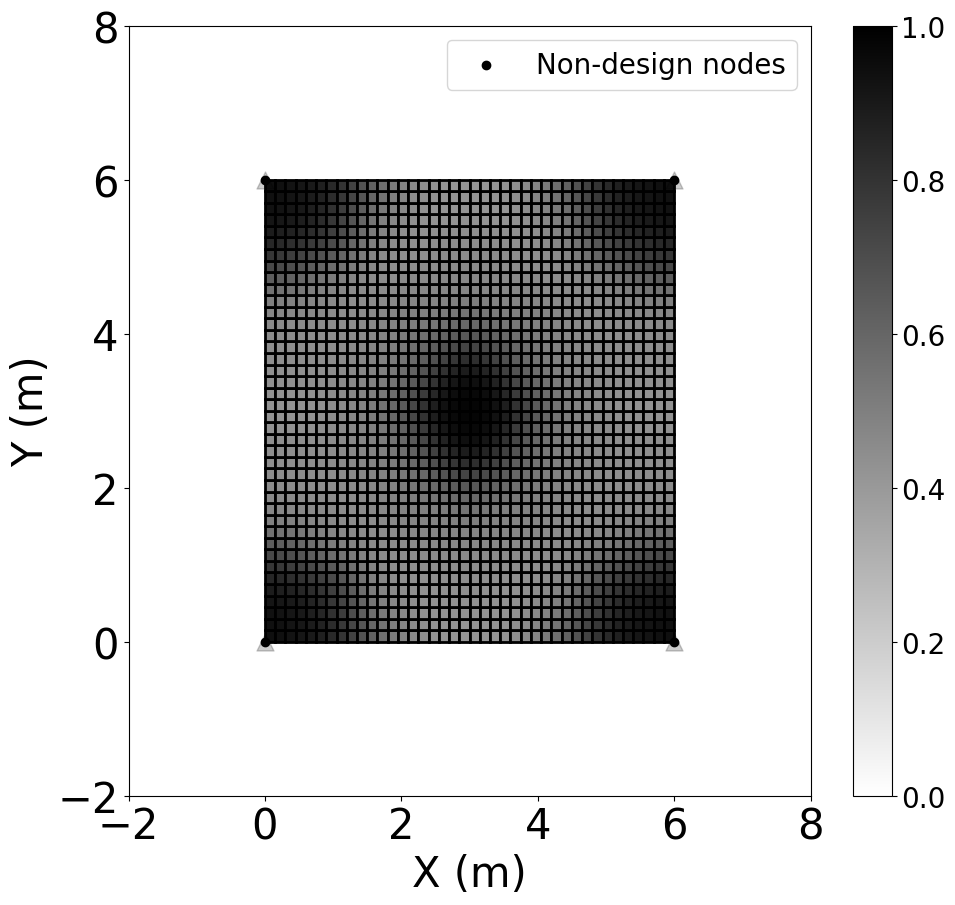

 69%|██████▉   | 141/205 [04:05<01:53,  1.78s/it]

Train epoch 142  ,loss:0.3625356212928199


 69%|██████▉   | 142/205 [04:07<01:44,  1.65s/it]

Train epoch 143  ,loss:0.36044523728619143


 70%|██████▉   | 143/205 [04:08<01:37,  1.57s/it]

Train epoch 144  ,loss:0.3570406240467046


 70%|███████   | 144/205 [04:09<01:31,  1.51s/it]

Train epoch 145  ,loss:0.3542423389931614
Train epoch 146  ,loss:0.35176292649487834
885.48126619401


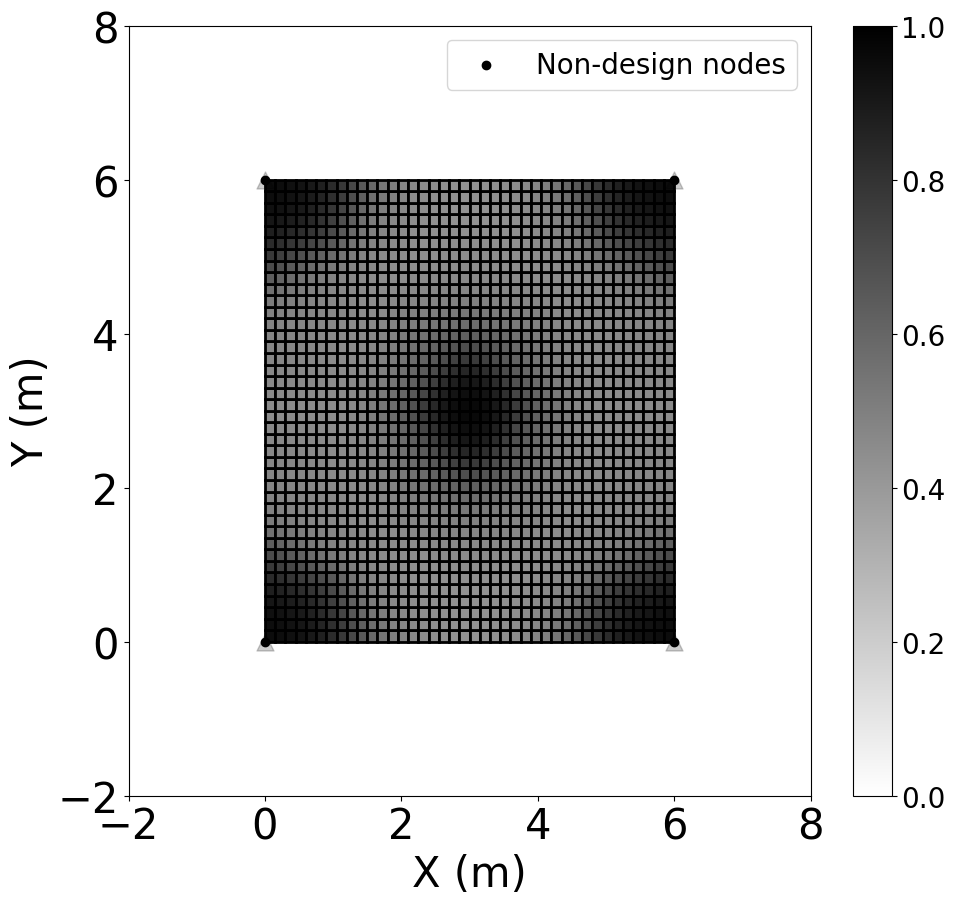

 71%|███████   | 146/205 [04:14<01:41,  1.72s/it]

Train epoch 147  ,loss:0.35059315593925133


 72%|███████▏  | 147/205 [04:15<01:33,  1.61s/it]

Train epoch 148  ,loss:0.349727150320588


 72%|███████▏  | 148/205 [04:16<01:27,  1.54s/it]

Train epoch 149  ,loss:0.3486977891901866


 73%|███████▎  | 149/205 [04:18<01:23,  1.49s/it]

Train epoch 150  ,loss:0.3483346176072431
Train epoch 151  ,loss:0.34667284429517814
887.0189505615201


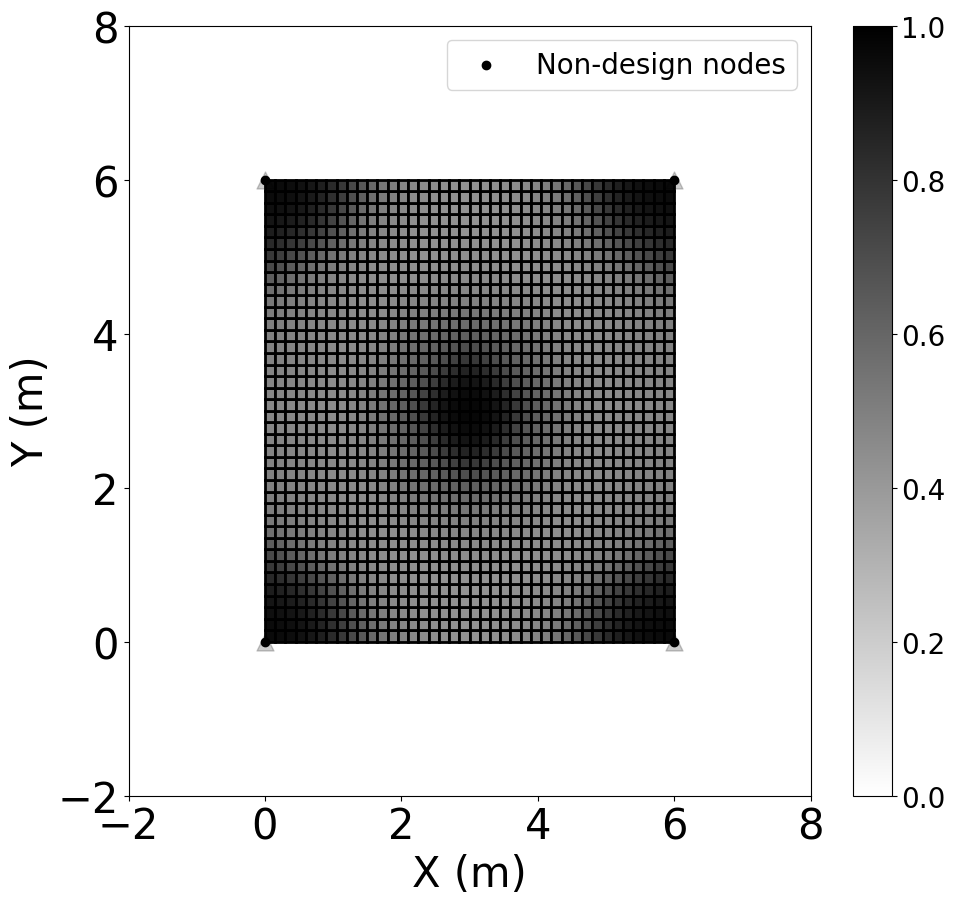

 74%|███████▎  | 151/205 [04:22<01:35,  1.78s/it]

Train epoch 152  ,loss:0.3452049149417918


 74%|███████▍  | 152/205 [04:23<01:27,  1.65s/it]

Train epoch 153  ,loss:0.344101749742799


 75%|███████▍  | 153/205 [04:25<01:21,  1.57s/it]

Train epoch 154  ,loss:0.3422704928411969


 75%|███████▌  | 154/205 [04:26<01:16,  1.51s/it]

Train epoch 155  ,loss:0.34120015591427877
Train epoch 156  ,loss:0.3404081453554615
884.9833746474378


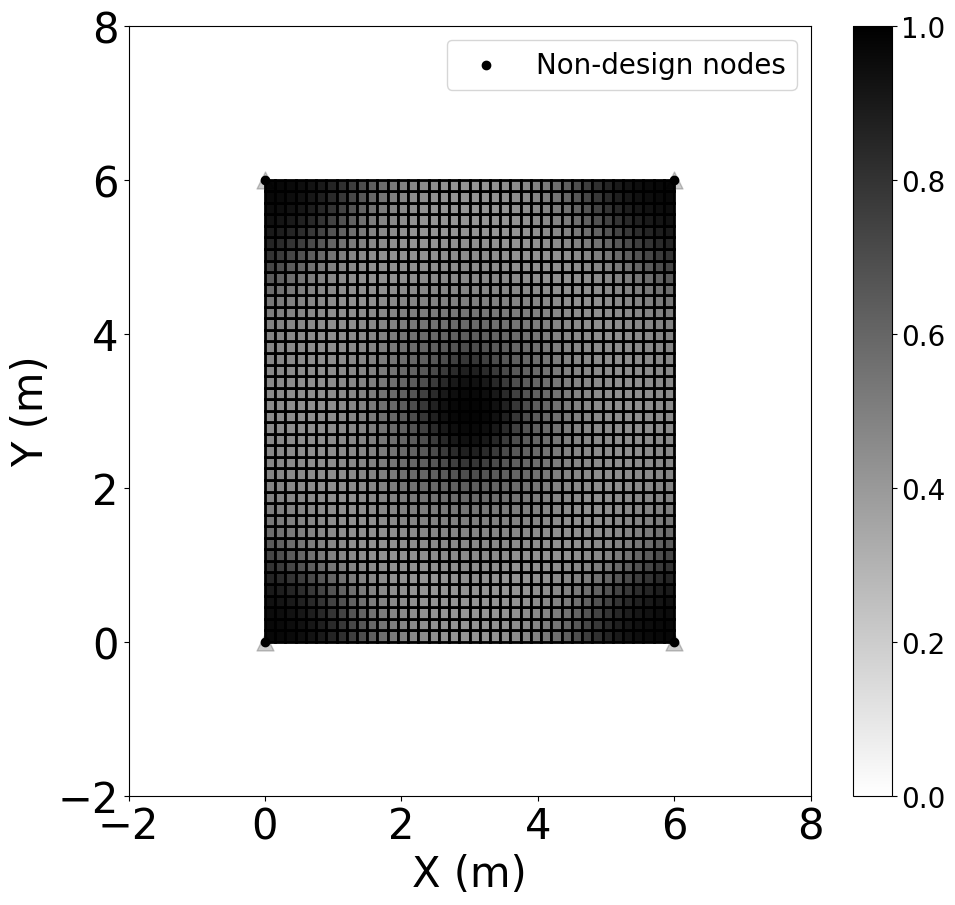

 76%|███████▌  | 156/205 [04:30<01:24,  1.72s/it]

Train epoch 157  ,loss:0.3391629400952984


 77%|███████▋  | 157/205 [04:32<01:17,  1.62s/it]

Train epoch 158  ,loss:0.3379184713461678


 77%|███████▋  | 158/205 [04:33<01:12,  1.54s/it]

Train epoch 159  ,loss:0.33668213088531457


 78%|███████▊  | 159/205 [04:34<01:08,  1.49s/it]

Train epoch 160  ,loss:0.33550919539293644
Train epoch 161  ,loss:0.33435417281772134
883.490285553134


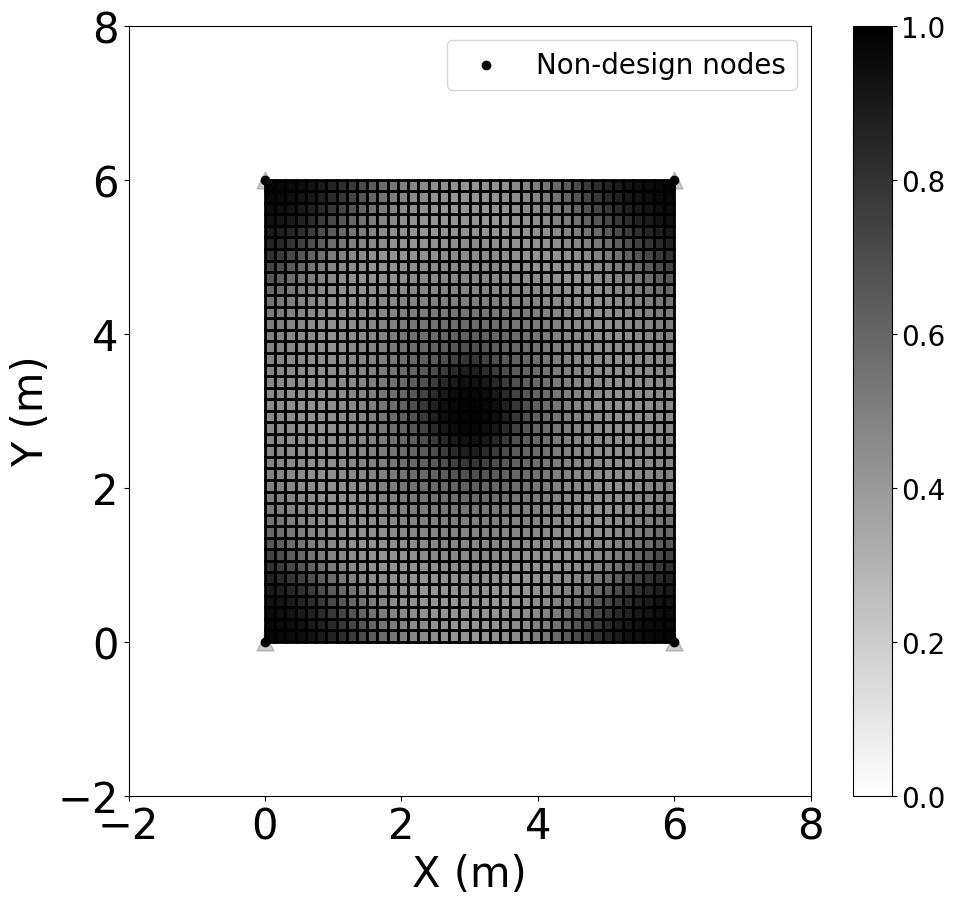

 79%|███████▊  | 161/205 [04:39<01:17,  1.77s/it]

Train epoch 162  ,loss:0.3334297046400773


 79%|███████▉  | 162/205 [04:40<01:11,  1.65s/it]

Train epoch 163  ,loss:0.3330685334825866


 80%|███████▉  | 163/205 [04:41<01:05,  1.57s/it]

Train epoch 164  ,loss:0.3329649162030205


 80%|████████  | 164/205 [04:43<01:01,  1.51s/it]

Train epoch 165  ,loss:0.3315581066497159
Train epoch 166  ,loss:0.32865406309556444
877.5577063353342


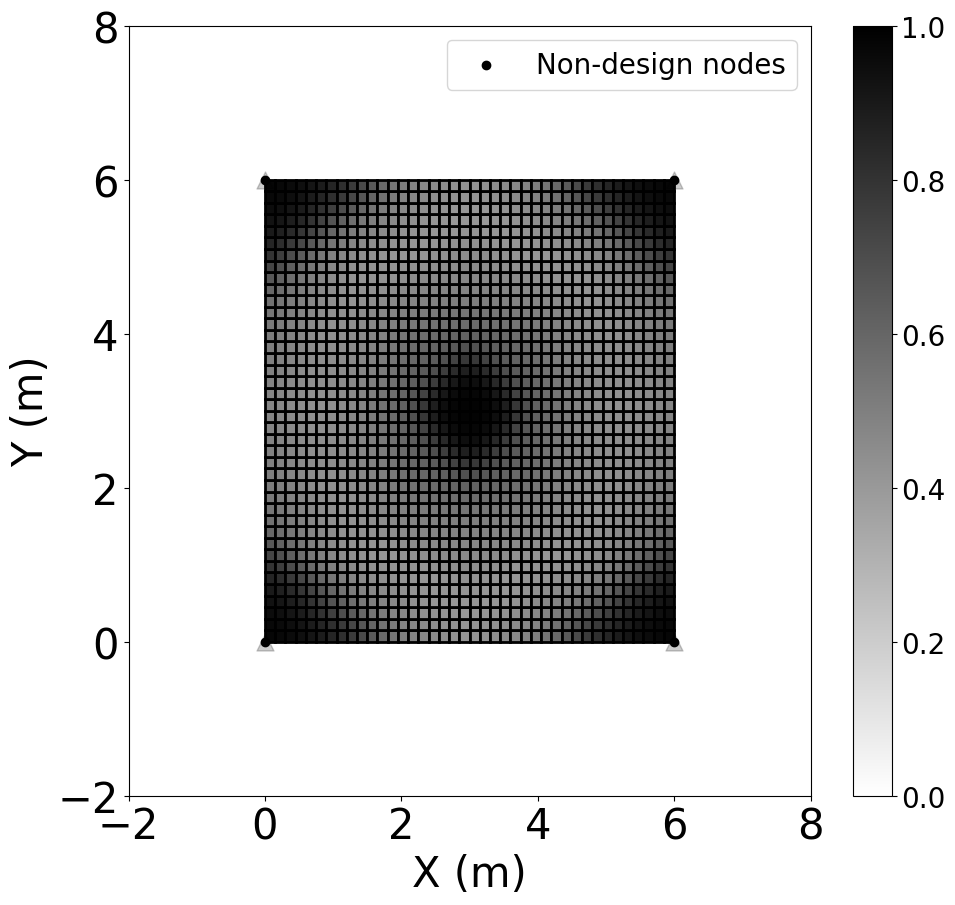

 81%|████████  | 166/205 [04:47<01:06,  1.71s/it]

Train epoch 167  ,loss:0.32663583799471585


 81%|████████▏ | 167/205 [04:48<01:01,  1.61s/it]

Train epoch 168  ,loss:0.3267517894356755


 82%|████████▏ | 168/205 [04:50<00:56,  1.54s/it]

Train epoch 169  ,loss:0.32667491750384675


 82%|████████▏ | 169/205 [04:51<00:53,  1.49s/it]

Train epoch 170  ,loss:0.3238184248532139
Train epoch 171  ,loss:0.321398143876499
879.8416166501082


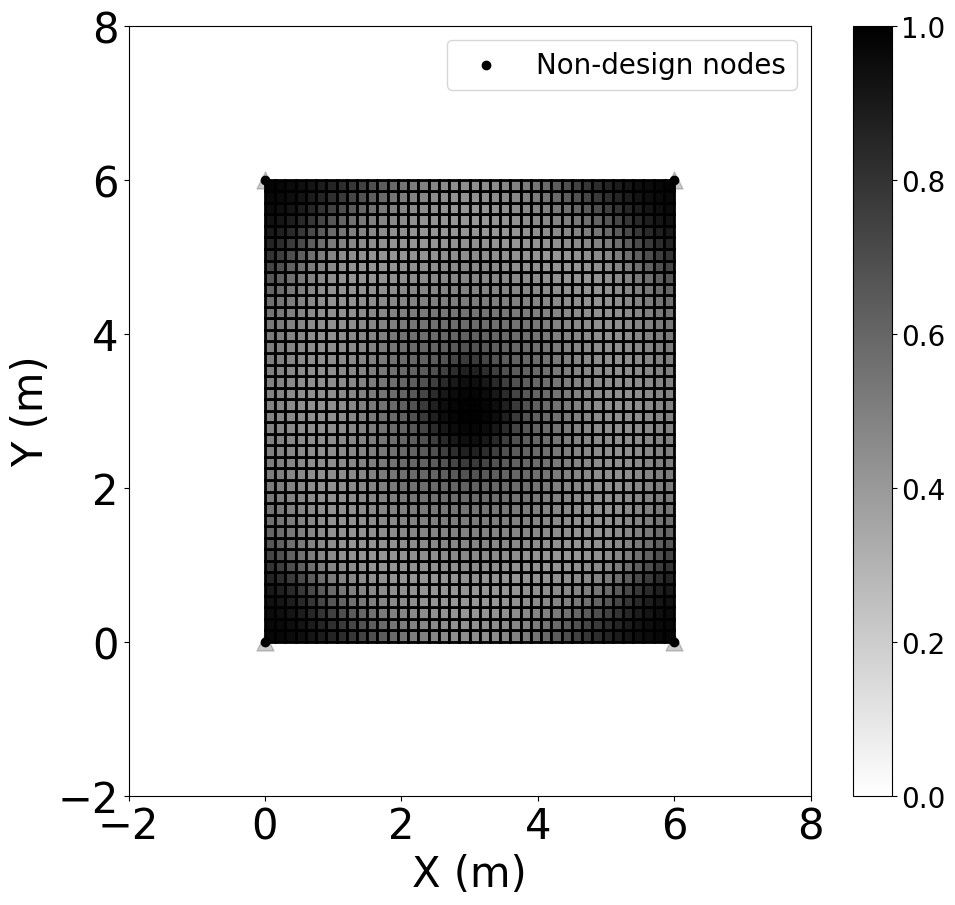

 83%|████████▎ | 171/205 [04:55<00:57,  1.70s/it]

Train epoch 172  ,loss:0.3211472101292204


 84%|████████▍ | 172/205 [04:56<00:52,  1.60s/it]

Train epoch 173  ,loss:0.3213148590263451


 84%|████████▍ | 173/205 [04:58<00:49,  1.53s/it]

Train epoch 174  ,loss:0.31982096408273386


 85%|████████▍ | 174/205 [04:59<00:46,  1.49s/it]

Train epoch 175  ,loss:0.3164866706230952
Train epoch 176  ,loss:0.3143342430751596
876.7532784533953


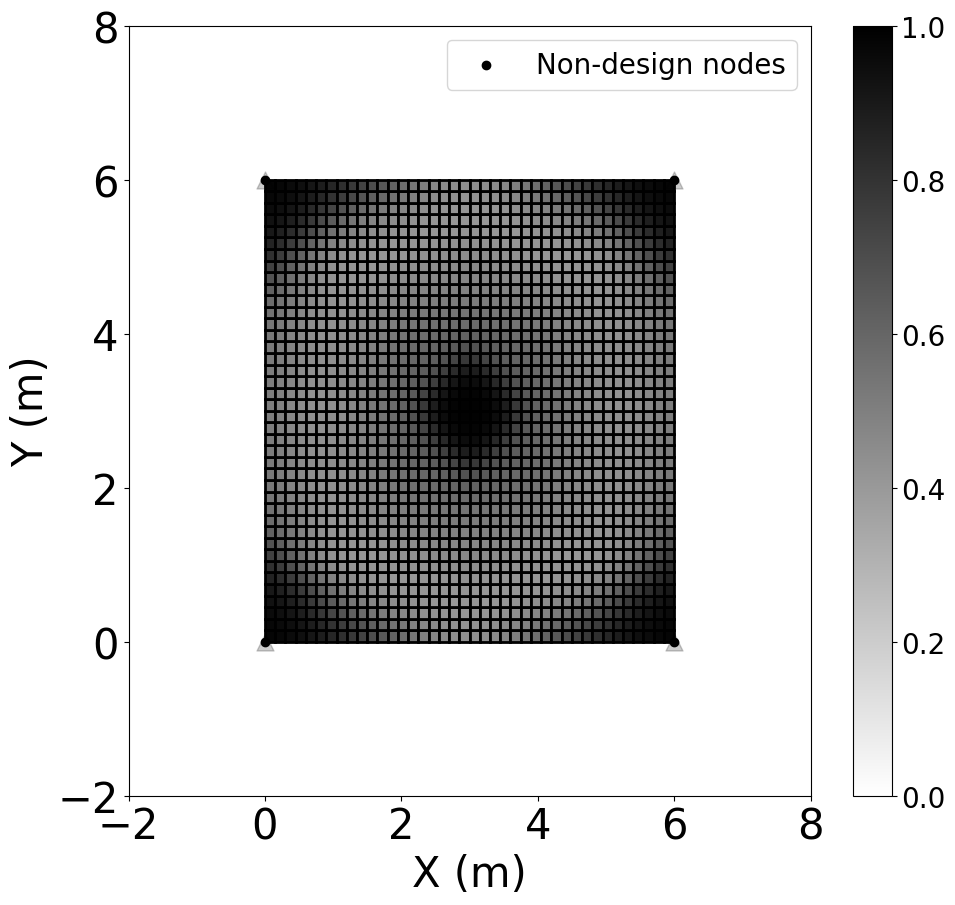

 86%|████████▌ | 176/205 [05:04<00:51,  1.78s/it]

Train epoch 177  ,loss:0.313973945593571


 86%|████████▋ | 177/205 [05:05<00:46,  1.65s/it]

Train epoch 178  ,loss:0.31429606380112046


 87%|████████▋ | 178/205 [05:06<00:42,  1.57s/it]

Train epoch 179  ,loss:0.3143747768118238


In [ ]:
trained_model_state = train_model(model_state, num_epochs=205)

In [ ]:
##Apply_fn: ML input to output
outs = trained_model_state.apply_fn(trained_model_state.params, inp) #how to move nodes along z, ML-Outpu
node_rho_params = outs.reshape(-1)


#Final density
mu_opt = jnp.average(node_rho_params[cnct],axis=1) #Average per-node density for each shell

In [125]:
non_design_nodes

array([  20,  820,  860, 1660])

In [130]:
design_nodes[20]

20

In [123]:
zs[non_design_nodes]

array([0.53679601, 2.9963183 , 1.62004906, 1.69808352])

# Visualization

In [ ]:
%matplotlib inline




fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,10)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
  #ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='black')


import matplotlib as mpl
cmap = mpl.colormaps['binary']
mu_opt_filtered = B_ij_shell@mu_opt
for i in range(n_ele):
    all_corners = []
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    all_corners.append([[xs[inode],ys[inode],zs_filtered[inode]],
                        [xs[jnode],ys[jnode],zs_filtered[jnode]],
                        [xs[mnode],ys[mnode],zs_filtered[mnode]],
                        [xs[nnode],ys[nnode],zs_filtered[nnode]],
                       ])
    #all_corners.append([[xs[inode],ys[inode],zs[inode]],
    #                    [xs[jnode],ys[jnode],zs[jnode]],
    #                    [xs[mnode],ys[mnode],zs[mnode]],
    #                    [xs[nnode],ys[nnode],zs[nnode]],
    #                   ])
    
    tdco = Poly3DCollection(all_corners)
    alpha = float(mu_opt_filtered[i])
    tdco.set_facecolor(cmap(alpha))
    tdco.set_edgecolor('black')
    ax.add_collection3d(tdco)
    


cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
cb.ax.tick_params(labelsize=20)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes]+0.35,color='black',label='Supported nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes]+0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(20, -135)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

In [ ]:

fig,ax = plt.subplots(figsize=(11,10))
ax.set_ylim(-0.75,6.75)
ax.set_xlim(-0.75,6.75)
plt.xlabel('X (m)',fontsize=30)
plt.ylabel('Y (m)',fontsize=30)
#ax = fig.add_subplot#(projection='3d')
#ax.set_zlim(0,20)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
all_corners= []
import matplotlib as mpl
cmap = mpl.colormaps['binary']
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
    alpha = float(mu_opt_filtered[i])
    #cthis_poly.set_alpha(alpha)
    this_poly.set_facecolor(cmap(alpha))
    this_poly.set_edgecolor('black')
    this_poly.set_lw(2)
    ax.add_patch(this_poly)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='black',label='Supported nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')


cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
cb.ax.tick_params(labelsize=20)
plt.legend(fontsize=20)# loc=(0.5,0.7))
ax.grid(False)
plt.show()

In [ ]:

fig,ax = plt.subplots(figsize=(11,10))
ax.set_ylim(-2,8)
ax.set_xlim(-2,8)
plt.xlabel('X (m)',fontsize=30)
plt.ylabel('Y (m)',fontsize=30)
#ax = fig.add_subplot#(projection='3d')
#ax.set_zlim(0,20)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
all_corners= []
import matplotlib as mpl
cmap = mpl.colormaps['binary']
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
    alpha = float(mu_opt[i])
    #cthis_poly.set_alpha(alpha)
    this_poly.set_facecolor(cmap(alpha))
    this_poly.set_edgecolor('black')
    this_poly.set_lw(2)
    ax.add_patch(this_poly)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')


cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
cb.ax.tick_params(labelsize=20)
plt.legend(fontsize=20)# loc=(0.5,0.7))
ax.grid(False)
plt.show()

In [89]:
jnp.sum(mu_opt)

Array(796.78191734, dtype=float64)

In [107]:
jnp.sum(mu_opt)

Array(800.34499146, dtype=float64)

In [108]:
0.5*sso_model.eleparameters_values.shape[0]

800.0

In [ ]:
mu_opt_filtered